In [85]:
import re
import os
import math
import sys
sys.path.append('..')
import numpy as np
import pandas as pd
pd.set_option('precision', 3)
import subprocess

from collections import  defaultdict
from operator import itemgetter
from scipy import interpolate

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

from autostop.utils import *

marker_dct = {0: u'tickleft', 1: u'tickright', 2: u'tickup', 3: u'tickdown', 4: u'caretleft', u'D': u'diamond', 
              6: u'caretup', 7: u'caretdown', u's': u'square', u'|': u'vline', None: u'nothing', u'None': u'nothing', 
              u'x': u'x', 5: u'caretright', u'_': u'hline', u'^': u'triangle_up', u' ': u'nothing', 
              u'd': u'thin_diamond', u'h': u'hexagon1', u'+': u'plus', u'*': u'star', u',': u'pixel', 
              u'o': u'circle', u'.': u'point', u'1': u'tri_down', u'p': u'pentagon', u'3': u'tri_left', 
              u'2': u'tri_up', u'4': u'tri_right', u'H': u'hexagon2', u'v': u'triangle_down', u'': u'nothing', 
              u'8': u'octagon', u'<': u'triangle_left', u'>': u'triangle_right'}

show_columns = ['recall', 'cost', 'reliability', 'loss_er', 're']

In [4]:
tar_master_dir = '/Users/danli/Documents/Project/autostop/autostop_project/tar-master'
datadir = '/Users/danli/Documents/Project/autostop/autostop_project/data'
retdir = '/Users/danli/Documents/Project/autostop/autostop_project/ret'
# figuredir = '/Users/danli/Documents/Project/autostop/autostop_project/figure'
paperfiguredir = '/Users/danli/Documents/GitProject/autostop/autostop/tois_paper/figures/'#'/Users/danli/Documents/'#

# Load Interaction result and TarRun result

In [6]:
def check_file(filepath):
    if not os.path.exists(filepath):
        print('not existing file {}'.format(filepath))
    if os.path.getsize(filepath) == 0:
        print('zero byte file {}'.format(filepath))

def get_model_name(model_name):
    model = model_name
    if 'random' in model_name:
        model = '0-random'
    if 'knee' in model_name:
        model = 'Knee'
    if 'scal' in model_name:
        model = 'SCAL'
    if 'target' in model_name:
        model ='Target'
    if 'sdtf' in model_name:
        model = 'SD-training'
    if 'sdfu' in model_name:
        model = 'SD-sampling'
    if 'autostop' in model_name:
        model = 'Ours'
    return model


def TarEvalResultReader(data_name, model_name, exp_id, train_test, topic_id):
    
    # run file
    runfile = os.path.join(retdir, data_name, 'tar_run', model_name, exp_id, train_test, topic_id + '.run')
    check_file(runfile)
    
    # qrel file
    qrelfile = os.path.join(datadir, data_name, 'abs_qrels', topic_id)
    check_file(qrelfile)
    
    # tar eval script
    script = os.path.join(tar_master_dir, 'scripts/tar_eval.py')
    
    # result
    ret = subprocess.check_output(['python', script, qrelfile, runfile])
    ret = subprocess.check_output([' tail -27 '], shell=True, input=ret)
    ret = ret.decode(encoding='utf-8')
   
    # dataframe
    dct = {}
    for line in ret.split('\n'):
      if line != '':
            tid, key, val = line.split()
            if tid == 'ALL':
                dct[key] = [float(val)]
    
    df = pd.DataFrame(dct)
    model = get_model_name(model_name)
    df['model_name'] = [model]
    df['exp_id'] = [exp_id]
    df['topic_id'] = [topic_id]
    df['recall'] = float(df['rels_found']) / float(df['num_rels'])
    df['cost'] = float(df['num_shown']) / float(df['num_docs'])
    return df


def InteractionLastResult(data_name, model_name, exp_id, train_test, topic_id):
    mdir = os.path.join(retdir, data_name, 'interaction', model_name, exp_id, train_test)
    filename = topic_id + '.csv'
    filepath = os.path.join(mdir, filename)
    
    check_file(filepath)
    model = get_model_name(model_name)
    
    df = pd.read_csv(filepath)
    df = df.iloc[-1:]  # last row
    df['model_name'] = [model]
    df['exp_id'] = [exp_id]
    df['topic_id'] = [topic_id]
    return df


def InteractionResultReader(data_name, model_name, exp_id, train_test, topic_id):
    mdir = os.path.join(retdir, data_name, 'interaction', model_name, exp_id, train_test)
    filename = topic_id + '.csv'
    filepath = os.path.join(mdir, filename)
    
    check_file(filepath)
    model = get_model_name(model_name)
    
    df = pd.read_csv(filepath)
    
    # construct new data
    startp, endp, nump = 0.1, 1.0, 10
    df = df.drop_duplicates(['sampled_num'])
    df['percentage'] = df['sampled_num'] / df['total_num']
    max_percentage = df['percentage'].max()
    min_percentage = df['percentage'].min()

    df['relative_error'] = np.abs(df['total_esti_r'] - df['total_true_r']) / df['total_true_r']
    df = df.fillna(0)

    x = np.linspace(startp, endp, nump)
    f = interpolate.InterpolatedUnivariateSpline(df['percentage'].values, df['relative_error'].values)
    relative_error = revised_f(x, f, min_percentage, max_percentage)
    f = interpolate.InterpolatedUnivariateSpline(df['percentage'].values, df['running_true_recall'].values)
    recall = revised_f(x, f, min_percentage, max_percentage)                                      
    f = interpolate.InterpolatedUnivariateSpline(df['percentage'].values, df['ap'].values)
    ap = revised_f(x, f, min_percentage, max_percentage)  
    
    df = pd.DataFrame({
                       'model_name': [model] * nump,
                        'exp_id': [exp_id] * nump,
                       'percentage': x, 
                       'relative_error': relative_error, 
                       'recall': recall,
                        'ap': ap})
    return df


def revised_f(x, f, min_percentage, max_percentage):
    y = []
    miny = f(min_percentage)
    maxy = f(max_percentage)
    for xi in x:
        if xi > max_percentage:
            y.append(maxy)
        elif xi < min_percentage:
            y.append(miny)
        else:
            y.append(f(xi))
    y = np.array(y)
    return y


def load_data(data_name, folders, exp_ids, topic_ids, func):
    dfs = []
    for folder in folders:
        for exp_id in exp_ids:
            for topic_id in topic_ids:
                try:
                    df = func(data_name, folder, exp_id, 'test', topic_id)
                    dfs.append(df)
                except Exception as e:
                    print(e,folder, exp_id, topic_id)
                    pass
    df = pd.concat(dfs, axis=0)
    return df

def pareto_frontier(Xs, Ys, maxX=True, maxY=True):
    '''
    Method to take two equally-sized lists and return just the elements which lie
    on the Pareto frontier, sorted into order.
    Default behaviour is to find the maximum for both X and Y, but the option is
    available to specify maxX = False or maxY = False to find the minimum for either
    or both of the parameters.
    '''

    # Sort the list in either ascending or descending order of X
    myList = sorted([[Xs[i], Ys[i]] for i in range(len(Xs))], reverse=maxX)
    # Start the Pareto frontier with the first value in the sorted list
    p_front = [myList[0]]
    # Loop through the sorted list
    for pair in myList[1:]:
        if maxY:
            if pair[1] >= p_front[-1][1]:  # Look for higher values of Y…
                p_front.append(pair)  # … and add them to the Pareto frontier
        else:
            if pair[1] <= p_front[-1][1]:  # Look for lower values of Y…
                p_front.append(pair)  # … and add them to the Pareto frontier
    # Turn resulting pairs back into a list of Xs and Ys
    p_frontX = [pair[0] for pair in p_front]
    p_frontY = [pair[1] for pair in p_front]
    return p_frontX, p_frontY




# AutoTAR

In [4]:
# dfs = []
# for topic_id in clef_2017_test_topics:
#     _df = TarEvalResultReader(data_name='clef2017', model_name='autotar_sp1.0_sr1.0_cttopicwise_md2_c1.0', exp_id='1', train_test='test', topic_id=topic_id)
#     dfs.append(_df)
# df = pd.concat(dfs, ignore_index=True)
# descdf = df[['wss_100', 'loss_er', 'norm_area', 'recall', 'cost', 'num_shown', 'num_docs', 'rels_found', 'num_rels', 'ap', 'NCG@10', 'NCG@100']]
# descdf.describe()

In [5]:
# dfs = []
# for topic_id in clef_2018_topics:
#     _df = TarEvalResultReader(data_name='clef2018', model_name='autotar_sp1.0_sr1.0_cttopicwise_md2_c1.0', exp_id='1', train_test='test', topic_id=topic_id)
#     dfs.append(_df)
# df = pd.concat(dfs, ignore_index=True)


In [6]:
# dfs = []
# for topic_id in clef_2019_topics:
#     _df = TarEvalResultReader(data_name='clef2019', model_name='autotar_sp1.0_sr1.0_cttopicwise_md2_c1.0', exp_id='1', train_test='test', topic_id=topic_id)
#     dfs.append(_df)
# df = pd.concat(dfs, ignore_index=True)


In [7]:
# dfs = []
# for topic_id in athome1_topics:
#     _df = TarEvalResultReader(data_name='athome1', model_name='autotar_sp0.5_sr1.0_cttopicwise_md2_c1.0', exp_id='1', train_test='test', topic_id=topic_id)
#     dfs.append(_df)
# df = pd.concat(dfs, ignore_index=True)
# df

# Knee

In [1]:
# dfs = []
# for topic_id in clef_2017_training_topics:
#     for rho in ['dynamic', 0.001,0.01, 0.1, 1, 2, 3, 6, 10]:
#         for beta in[100.0, 1000.0]:
#             _df = TarEvalResultReader(data_name='clef2017', model_name='knee_sb{}_sp1.0_sr1.0_rho{}_cttopicwise_md2_c1.0'.format(str(beta), str(rho)), exp_id='1', train_test='train', topic_id=topic_id)
#             _df['bound'] = rho
#             _df['beta'] = beta
#             dfs.append(_df)
# df = pd.concat(dfs, ignore_index=True)
# df = df.groupby(['bound', 'beta']).mean()
# df[['cost', 'recall','loss_er']]   # 'wss_100', 'loss_er', 'norm_area', 'recall', 'cost', 'total_cost', 'num_docs','ap'

In [9]:
dfs = []
for topic_id in clef_2017_test_topics:
    for rho in ['dynamic']:
        for beta in[1000.0]:
            _df = TarEvalResultReader(data_name='clef2017', model_name='knee_sb{}_sp1.0_sr1.0_rho{}_cttopicwise_md2_c1.0'.format(str(beta), str(rho)), exp_id='1', train_test='test', topic_id=topic_id)
            _df['bound'] = rho
            _df['beta'] = beta
            dfs.append(_df)
df = pd.concat(dfs, ignore_index=True)
df = df.groupby(['bound', 'beta']).mean()

df[['cost', 'recall','loss_er']]  

,,cost,recall,loss_er
bound,beta,,,
dynamic,1000.0,0.291,0.998,0.041


In [10]:
dfs = []
for topic_id in athome1_topics:
    for rho in ['dynamic']:
        for beta in[1000.0]:
            _df = TarEvalResultReader(data_name='athome1', model_name='knee_sb{}_sp1.0_sr1.0_rho{}_cttopicwise_md2_c1.0'.format(str(beta), str(rho)), exp_id='1', train_test='test', topic_id=topic_id)
            _df['bound'] = rho
            _df['beta'] = beta
            dfs.append(_df)
df = pd.concat(dfs, ignore_index=True)
# df = df.groupby(['bound', 'beta']).mean()

df[['cost', 'num_shown',  'recall','loss_er']]  


,cost,num_shown,recall,loss_er
0,30.626,139105.0,1.000,0.000
1,1.771,10336.0,0.996,0.000
2,2.368,3846.0,0.909,0.012
3,1.484,8498.0,0.994,0.000
4,4.868,1105.0,0.846,0.117
5,2.579,9373.0,0.820,0.033
6,1.444,24749.0,0.996,0.000
7,1.978,4697.0,0.968,0.003
8,3.578,8498.0,0.933,0.006
9,2.711,1372.0,0.980,0.028


# Knee: $\rho$, $\beta$

## athome1 athome4

In [37]:
dfs = []
for topic_id in athome1_topics:
    for rho in ['dynamic', 3, 6, 10]:
        for beta in[100.0, 1000.0]:
            _df = TarEvalResultReader(data_name='athome1', model_name='knee_sb{}_sp1.0_sr1.0_rho{}_cttopicwise_md2_c1.0'.format(str(beta), str(rho)), exp_id='1', train_test='train', topic_id=topic_id)
            _df['rho'] = rho
            _df['beta'] = beta
            dfs.append(_df)
df = pd.concat(dfs, ignore_index=True)
df['reliability'] = df.apply(lambda row:1 if row['recall'] >= 1.0 else 0, axis=1)
df['re'] = np.abs(df['recall'] - 1.0) / 1.0
df = df.groupby(['rho', 'beta']).mean()
df[show_columns]

recall   cost  reliability  loss_er     re
rho     beta                                              
3       100.0    0.935  4.726            0    0.021  0.065
        1000.0   0.935  4.726            0    0.021  0.065
6       100.0    0.960  5.819            0    0.016  0.040
        1000.0   0.960  5.819            0    0.016  0.040
10      100.0    0.970  7.545            0    0.015  0.030
        1000.0   0.970  7.545            0    0.015  0.030
dynamic 100.0    0.966  8.577            0    0.016  0.034
        1000.0   0.966  8.577            0    0.016  0.034

In [38]:
dfs = []
for topic_id in athome4_topics:
    for rho in [10]:
        for beta in[1000.0]:
            _df = TarEvalResultReader(data_name='athome4', model_name='knee_sb{}_sp1.0_sr1.0_rho{}_cttopicwise_md2_c1.0'.format(str(beta), str(rho)), exp_id='1', train_test='test', topic_id=topic_id)
            _df['rho'] = rho
            _df['beta'] = beta
            dfs.append(_df)
df = pd.concat(dfs, ignore_index=True)
df['reliability'] = df.apply(lambda row:1 if row['recall'] >= 1.0 else 0, axis=1)
df['re'] = np.abs(df['recall'] - 1.0) / 1.0
descdf = df[show_columns]
descdf.describe()


,recall,cost,reliability,loss_er,re
count,34.000,3.400e+01,34.000,34.000,34.000
mean,0.960,1.635e-02,0.088,0.005,0.040
std,0.056,4.142e-02,0.288,0.016,0.056
min,0.690,3.240e-04,0.000,0.000,0.000
25%,0.954,3.809e-03,0.000,0.000,0.012
50%,0.976,5.288e-03,0.000,0.001,0.024
75%,0.988,1.430e-02,0.000,0.002,0.046
max,1.000,2.455e-01,1.000,0.096,0.310


## legal

In [13]:
dfs = []
for topic_id in legal_t10_interactive_training_topics:
    for rho in ['dynamic', 3, 6, 10]:
        for beta in[100.0, 1000.0]:
            _df = TarEvalResultReader(data_name='legal', model_name='knee_sb{}_sp1.0_sr1.0_rho{}_cttopicwise_md2_c1.0'.format(str(beta), str(rho)), exp_id='1', train_test='train', topic_id=topic_id)
            _df['rho'] = rho
            _df['beta'] = beta
            dfs.append(_df)
df = pd.concat(dfs, ignore_index=True)
df['reliability'] = df.apply(lambda row:1 if row['recall'] >= 1.0 else 0, axis=1)
df = df.groupby(['rho', 'beta']).mean()
df[show_columns]

wss_100  loss_er  norm_area  recall  num_shown  num_docs  \
rho     beta                                                               
3       100.0     0.000    0.550      0.339   0.340     4819.0  685592.0   
        1000.0    0.000    0.056      0.772   0.791    47803.0  685592.0   
6       100.0     0.000    0.550      0.339   0.340     4935.0  685592.0   
        1000.0    0.000    0.052      0.795   0.819    81213.0  685592.0   
10      100.0     0.000    0.044      0.815   0.840   108201.0  685592.0   
        1000.0    0.000    0.044      0.815   0.840   108201.0  685592.0   
dynamic 100.0     0.123    0.014      0.895   0.928   282871.0  685592.0   
        1000.0    0.123    0.014      0.895   0.928   282871.0  685592.0   

                rels_found  num_rels     ap  NCG@10  NCG@100  reliability  
rho     beta                                                               
3       100.0         71.5     520.0  0.006   0.000    0.000          0.0  
        1000.0       446.0     520.0  0.013   0.419    0.419          0.0  
6       100.0         71.5     520.0  0.006   0.000    0.000          0.0  
        1000.0       469.0     520.0  0.014   0.419    0.474          0.0  
10      100.0        478.0     520.0  0.014   0.419    0.474          0.0  
        1000.0       478.0     520.0  0.014   0.419    0.474          0.0  
dynamic 100.0        505.0     520.0  0.015   0.419    0.499          0.5  
        1000.0       505.0     520.0  0.015   0.419    0.499          0.5

In [39]:
dfs = []
for topic_id in legal_t10_interactive_test_topics:
    for rho in ['dynamic']:
        for beta in[1000.0]:
            _df = TarEvalResultReader(data_name='legal', model_name='knee_sb{}_sp1.0_sr1.0_rho{}_cttopicwise_md2_c1.0'.format(str(beta), str(rho)), exp_id='1', train_test='test', topic_id=topic_id)
            _df['rho'] = rho
            _df['beta'] = beta
            dfs.append(_df)
df = pd.concat(dfs, ignore_index=True)
df['reliability'] = df.apply(lambda row:1 if row['recall'] >= 1.0 else 0, axis=1)
df['re'] = np.abs(df['recall'] - 1.0) / 1.0
descdf = df[show_columns]
descdf.describe()


,recall,cost,reliability,loss_er,re
count,2.000,2.000,2.000,2.000,2.000
mean,0.966,0.287,0.500,0.004,0.034
std,0.048,0.272,0.707,0.002,0.048
min,0.932,0.094,0.000,0.002,0.000
25%,0.949,0.191,0.250,0.003,0.017
50%,0.966,0.287,0.500,0.004,0.034
75%,0.983,0.383,0.750,0.004,0.051
max,1.000,0.479,1.000,0.005,0.068


## clef 2017/2018/2019

In [73]:
dfs = []
for topic_id in clef_2017_training_topics:
    for rho in ['dynamic', 3, 6, 10]:
        for beta in[100.0, 1000.0]:
            _df = TarEvalResultReader(data_name='clef2017', model_name='knee_sb{}_sp1.0_sr1.0_rho{}_cttopicwise_md2_c1.0'.format(str(beta), str(rho)), exp_id='1', train_test='train', topic_id=topic_id)
            _df['rho'] = rho
            _df['beta'] = beta
            dfs.append(_df)
df = pd.concat(dfs, ignore_index=True)
df['reliability'] = df.apply(lambda row:1 if row['recall'] >= 1.0 else 0, axis=1)
df = df.groupby(['rho', 'beta']).mean()
df[['wss_100', 'loss_er', 'norm_area', 'recall', 'cost', 'num_shown', 'num_docs', 'rels_found', 'num_rels', 'ap', 'NCG@10', 'NCG@100', 'reliability']]

wss_100  loss_er  norm_area  recall   cost  num_shown  \
rho     beta                                                            
3       100.0     0.174    0.086      0.894   0.968  0.310    647.417   
        1000.0    0.419    0.107      0.907   0.986  0.393    859.083   
6       100.0     0.238    0.086      0.903   0.980  0.327    751.917   
        1000.0    0.419    0.107      0.910   0.990  0.404    944.000   
10      100.0     0.309    0.087      0.908   0.986  0.356    936.333   
        1000.0    0.419    0.108      0.913   0.995  0.425   1104.083   
dynamic 100.0     0.529    0.114      0.916   0.998  0.447   1493.833   
        1000.0    0.529    0.114      0.916   0.998  0.447   1493.833   

                num_docs  rels_found  num_rels     ap  NCG@10  NCG@100  \
rho     beta                                                             
3       100.0   4494.167      91.167    95.667  0.325   0.342    0.729   
        1000.0  4494.167      92.250    95.667  0.327   0.342    0.761   
6       100.0   4494.167      93.083    95.667  0.327   0.418    0.832   
        1000.0  4494.167      93.833    95.667  0.328   0.418    0.840   
10      100.0   4494.167      94.417    95.667  0.327   0.418    0.836   
        1000.0  4494.167      95.083    95.667  0.328   0.418    0.843   
dynamic 100.0   4494.167      94.667    95.667  0.328   0.418    0.847   
        1000.0  4494.167      94.667    95.667  0.328   0.418    0.847   

                reliability  
rho     beta                 
3       100.0         0.333  
        1000.0        0.750  
6       100.0         0.417  
        1000.0        0.750  
10      100.0         0.500  
        1000.0        0.750  
dynamic 100.0         0.917  
        1000.0        0.917

In [40]:
dfs = []
for topic_id in clef_2017_test_topics:
    for rho in ['dynamic']:
        for beta in[1000.0]:
            _df = TarEvalResultReader(data_name='clef2017', model_name='knee_sb{}_sp1.0_sr1.0_rho{}_cttopicwise_md2_c1.0'.format(str(beta), str(rho)), exp_id='1', train_test='test', topic_id=topic_id)
            _df['rho'] = rho
            _df['beta'] = beta
            dfs.append(_df)
df = pd.concat(dfs, ignore_index=True)
df['reliability'] = df.apply(lambda row:1 if row['recall'] >= 1.0 else 0, axis=1)
df['re'] = np.abs(df['recall'] - 1.0) / 1.0
descdf = df[show_columns]
descdf.describe()

,recall,cost,reliability,loss_er,re
count,30.000,30.000,30.000,30.000,30.000
mean,0.998,0.291,0.833,0.041,0.002
std,0.006,0.194,0.379,0.081,0.006
min,0.976,0.009,0.000,0.000,0.000
25%,1.000,0.140,1.000,0.007,0.000
50%,1.000,0.278,1.000,0.026,0.000
75%,1.000,0.384,1.000,0.046,0.000
max,1.000,0.739,1.000,0.451,0.024


In [43]:
dfs = []
for topic_id in clef_2018_topics:
    for rho in ['dynamic']:
        for beta in[1000.0]:
            _df = TarEvalResultReader(data_name='clef2018', model_name='knee_sb{}_sp1.0_sr1.0_rho{}_cttopicwise_md2_c1.0'.format(str(beta), str(rho)), exp_id='1', train_test='test', topic_id=topic_id)
            _df['rho'] = rho
            _df['beta'] = beta
            dfs.append(_df)
df = pd.concat(dfs, ignore_index=True)
df['reliability'] = df.apply(lambda row:1 if row['recall'] >= 1.0 else 0, axis=1)
df['re'] = np.abs(df['recall'] - 1.0) / 1.0
descdf = df[show_columns]
descdf.describe()

,recall,cost,reliability,loss_er,re
count,30.000,30.000,30.000,30.000,30.000
mean,0.994,0.328,0.700,0.047,0.006
std,0.013,0.258,0.466,0.080,0.013
min,0.952,0.018,0.000,0.000,0.000
25%,0.995,0.140,0.000,0.004,0.000
50%,1.000,0.222,1.000,0.015,0.000
75%,1.000,0.459,1.000,0.068,0.005
max,1.000,0.935,1.000,0.412,0.048


In [44]:
dfs = []
for topic_id in clef_2019_topics:
    for rho in ['dynamic']:
        for beta in[1000.0]:
            _df = TarEvalResultReader(data_name='clef2019', model_name='knee_sb{}_sp1.0_sr1.0_rho{}_cttopicwise_md2_c1.0'.format(str(beta), str(rho)), exp_id='1', train_test='test', topic_id=topic_id)
            _df['rho'] = rho
            _df['beta'] = beta
            dfs.append(_df)
df = pd.concat(dfs, ignore_index=True)
df['reliability'] = df.apply(lambda row:1 if row['recall'] >= 1.0 else 0, axis=1)
df['re'] = np.abs(df['recall'] - 1.0) / 1.0
descdf = df[show_columns]
descdf.describe()

,recall,cost,reliability,loss_er,re
count,31.000,31.000,31.000,31.000,31.000
mean,0.998,0.420,0.968,0.122,0.002
std,0.009,0.311,0.180,0.160,0.009
min,0.948,0.013,0.000,0.000,0.000
25%,1.000,0.123,1.000,0.010,0.000
50%,1.000,0.372,1.000,0.051,0.000
75%,1.000,0.674,1.000,0.171,0.000
max,1.000,1.000,1.000,0.588,0.052


# SD-training 

## clef 2017 2018 2019

In [45]:
dfs = []
for topic_id in clef_2017_test_topics:
    for tr in [0.8, 0.9, 0.99]:
        _df = TarEvalResultReader(data_name='clef2017', model_name='sdtf_tr{}'.format(str(tr)), exp_id='1', train_test='test', topic_id=topic_id)
        _df['tr'] = tr
        dfs.append(_df)
df = pd.concat(dfs, ignore_index=True)
df['reliability'] = df.apply(lambda row:1 if row['recall'] >= row['tr'] else 0, axis=1)
df['re'] = np.abs(df['recall'] - df['tr']) / df['tr']

In [46]:
descdf = df[df['tr'] == 0.8][show_columns]
descdf.describe()

,recall,cost,reliability,loss_er,re
count,30.000,30.000,30.000,30.000,30.000
mean,0.881,0.417,0.767,0.109,0.148
std,0.113,0.068,0.430,0.062,0.088
min,0.589,0.252,0.000,0.031,0.000
25%,0.802,0.369,1.000,0.057,0.085
50%,0.912,0.430,1.000,0.099,0.150
75%,0.979,0.466,1.000,0.130,0.243
max,1.000,0.541,1.000,0.251,0.263


In [47]:
descdf = df[df['tr'] == 0.9][show_columns]
descdf.describe()

,recall,cost,reliability,loss_er,re
count,30.000,30.000,30.000,30.000,30.000
mean,0.955,0.691,0.833,0.233,0.080
std,0.057,0.054,0.379,0.148,0.034
min,0.821,0.562,0.000,0.012,0.000
25%,0.935,0.642,1.000,0.104,0.069
50%,0.973,0.715,1.000,0.199,0.088
75%,1.000,0.730,1.000,0.347,0.111
max,1.000,0.756,1.000,0.520,0.111


In [48]:
descdf = df[df['tr'] == 0.99][show_columns]
descdf.describe()

,recall,cost,reliability,loss_er,re
count,30.000,30.000,30.000,30.000,30.000
mean,0.999,0.997,0.967,0.466,0.010
std,0.003,0.007,0.183,0.292,0.001
min,0.985,0.976,0.000,0.020,0.004
25%,1.000,0.999,1.000,0.224,0.010
50%,1.000,1.000,1.000,0.445,0.010
75%,1.000,1.000,1.000,0.641,0.010
max,1.000,1.000,1.000,0.980,0.010


### clef 2018

In [49]:
dfs = []
for topic_id in clef_2018_topics:
    for tr in [0.8, 0.9, 0.99]:
        _df = TarEvalResultReader(data_name='clef2018', model_name='sdtf_tr{}'.format(str(tr)), exp_id='1', train_test='test', topic_id=topic_id)
        _df['tr'] = tr
        dfs.append(_df)
df = pd.concat(dfs, ignore_index=True)
df['reliability'] = df.apply(lambda row:1 if row['recall'] >= row['tr'] else 0, axis=1)
df['re'] = np.abs(df['recall'] - df['tr']) / df['tr']

In [50]:
descdf = df[df['tr'] == 0.8][show_columns]
descdf.describe()

,recall,cost,reliability,loss_er,re
count,30.000,30.000,30.000,30.000,30.000
mean,0.886,0.414,0.833,0.086,0.141
std,0.094,0.059,0.379,0.055,0.074
min,0.622,0.287,0.000,0.024,0.011
25%,0.848,0.380,1.000,0.047,0.089
50%,0.903,0.413,1.000,0.073,0.134
75%,0.953,0.454,1.000,0.102,0.212
max,1.000,0.515,1.000,0.243,0.250


In [51]:
descdf = df[df['tr'] == 0.9][show_columns]
descdf.describe()

,recall,cost,reliability,loss_er,re
count,30.000,30.000,30.000,30.000,30.000
mean,0.972,0.701,0.967,0.196,0.082
std,0.033,0.038,0.183,0.138,0.030
min,0.865,0.621,0.000,0.012,0.004
25%,0.957,0.684,1.000,0.057,0.063
50%,0.980,0.709,1.000,0.195,0.089
75%,1.000,0.722,1.000,0.324,0.111
max,1.000,0.793,1.000,0.447,0.111


In [52]:
descdf = df[df['tr'] == 0.99][show_columns]
descdf.describe()

,recall,cost,reliability,loss_er,re
count,30.0,30.000,30.0,30.000,30.00
mean,1.0,0.996,1.0,0.394,0.01
std,0.0,0.008,0.0,0.277,0.00
min,1.0,0.972,1.0,0.020,0.01
25%,1.0,0.997,1.0,0.113,0.01
50%,1.0,1.000,1.0,0.381,0.01
75%,1.0,1.000,1.0,0.608,0.01
max,1.0,1.000,1.0,0.857,0.01


### clef 2019

In [53]:
dfs = []
for topic_id in clef_2019_topics:
    for tr in [0.8, 0.9, 0.99]:
        _df = TarEvalResultReader(data_name='clef2019', model_name='sdtf_tr{}'.format(str(tr)), exp_id='1', train_test='test', topic_id=topic_id)
        _df['tr'] = tr
        dfs.append(_df)
df = pd.concat(dfs, ignore_index=True)
df['reliability'] = df.apply(lambda row:1 if row['recall'] >= row['tr'] else 0, axis=1)
df['re'] = np.abs(df['recall'] - df['tr']) / df['tr']

In [54]:
descdf = df[df['tr'] == 0.8][show_columns]
descdf.describe()

,recall,cost,reliability,loss_er,re
count,31.000,31.000,31.000,31.000,31.000
mean,0.826,0.421,0.613,0.146,0.155
std,0.153,0.066,0.495,0.085,0.114
min,0.422,0.301,0.000,0.046,0.007
25%,0.753,0.375,0.000,0.099,0.050
50%,0.833,0.423,1.000,0.131,0.151
75%,0.952,0.467,1.000,0.160,0.250
max,1.000,0.544,1.000,0.421,0.472


In [55]:
descdf = df[df['tr'] == 0.9][show_columns]
descdf.describe()

,recall,cost,reliability,loss_er,re
count,31.000,31.000,31.000,31.000,31.000
mean,0.940,0.713,0.774,0.295,0.092
std,0.100,0.043,0.425,0.156,0.075
min,0.500,0.650,0.000,0.041,0.003
25%,0.916,0.685,1.000,0.176,0.045
50%,0.984,0.703,1.000,0.289,0.111
75%,1.000,0.733,1.000,0.395,0.111
max,1.000,0.842,1.000,0.726,0.444


In [56]:
descdf = df[df['tr'] == 0.99][show_columns]
descdf.describe()

,recall,cost,reliability,loss_er,re
count,31.000,31.000,31.000,31.000,31.000
mean,0.999,0.992,0.968,0.545,0.010
std,0.004,0.016,0.180,0.262,0.001
min,0.977,0.929,0.000,0.057,0.005
25%,1.000,0.994,1.000,0.341,0.010
50%,1.000,0.999,1.000,0.487,0.010
75%,1.000,1.000,1.000,0.800,0.010
max,1.000,1.000,1.000,0.960,0.013


### athome4

In [57]:
dfs = []
for topic_id in athome4_topics:
    for tr in [0.8, 0.9, 0.99]:
        _df = TarEvalResultReader(data_name='athome4', model_name='sdtf_tr{}'.format(str(tr)), exp_id='1', train_test='test', topic_id=topic_id)
        _df['tr'] = tr
        dfs.append(_df)
df = pd.concat(dfs, ignore_index=True)
df['reliability'] = df.apply(lambda row:1 if row['recall'] >= row['tr'] else 0, axis=1)
df['re'] = np.abs(df['recall'] - df['tr']) / df['tr']

In [58]:
descdf = df[df['tr'] == 0.8][show_columns]
descdf.describe()

,recall,cost,reliability,loss_er,re
count,34.0,3.400e+01,34.0,34.000,34.00
mean,1.0,1.000e+00,1.0,0.122,0.25
std,0.0,2.254e-16,0.0,0.173,0.00
min,1.0,1.000e+00,1.0,0.000,0.25
25%,1.0,1.000e+00,1.0,0.009,0.25
50%,1.0,1.000e+00,1.0,0.029,0.25
75%,1.0,1.000e+00,1.0,0.189,0.25
max,1.0,1.000e+00,1.0,0.683,0.25


In [59]:
descdf = df[df['tr'] == 0.9][show_columns]
descdf.describe()

,recall,cost,reliability,loss_er,re
count,34.0,3.400e+01,34.0,34.000,34.000
mean,1.0,1.000e+00,1.0,0.122,0.111
std,0.0,2.254e-16,0.0,0.173,0.000
min,1.0,1.000e+00,1.0,0.000,0.111
25%,1.0,1.000e+00,1.0,0.009,0.111
50%,1.0,1.000e+00,1.0,0.029,0.111
75%,1.0,1.000e+00,1.0,0.189,0.111
max,1.0,1.000e+00,1.0,0.683,0.111


In [60]:
descdf = df[df['tr'] == 0.99][show_columns]
descdf.describe()

,recall,cost,reliability,loss_er,re
count,34.0,3.400e+01,34.0,34.000,34.00
mean,1.0,1.000e+00,1.0,0.122,0.01
std,0.0,2.254e-16,0.0,0.173,0.00
min,1.0,1.000e+00,1.0,0.000,0.01
25%,1.0,1.000e+00,1.0,0.009,0.01
50%,1.0,1.000e+00,1.0,0.029,0.01
75%,1.0,1.000e+00,1.0,0.189,0.01
max,1.0,1.000e+00,1.0,0.683,0.01


## legal

In [61]:
dfs = []
for topic_id in legal_t10_interactive_test_topics:
    for target_recall in [0.8, 0.9, 0.99]:
        try:
            _df = TarEvalResultReader(data_name='legal', model_name='sdtf_tr{}'.format(str(target_recall)), exp_id='1', train_test='test', topic_id=topic_id)
            _df['tr'] = target_recall
            dfs.append(_df)
        except:
            print(topic_id)
df = pd.concat(dfs, ignore_index=True)
df['reliability'] = df.apply(lambda row:1 if row['recall'] > row['tr'] else 0, axis=1)
df['re'] = np.abs(df['recall'] - df['tr']) / df['tr']

In [62]:
descdf = df[df['tr'] == 0.8][show_columns]
descdf.describe()

,recall,cost,reliability,loss_er,re
count,2.0,2.0,2.0,2.000,2.00
mean,1.0,1.0,1.0,0.007,0.25
std,0.0,0.0,0.0,0.002,0.00
min,1.0,1.0,1.0,0.006,0.25
25%,1.0,1.0,1.0,0.007,0.25
50%,1.0,1.0,1.0,0.007,0.25
75%,1.0,1.0,1.0,0.008,0.25
max,1.0,1.0,1.0,0.009,0.25


In [63]:
descdf = df[df['tr'] == 0.9][show_columns]
descdf.describe()

,recall,cost,reliability,loss_er,re
count,2.0,2.0,2.0,2.000,2.000
mean,1.0,1.0,1.0,0.007,0.111
std,0.0,0.0,0.0,0.002,0.000
min,1.0,1.0,1.0,0.006,0.111
25%,1.0,1.0,1.0,0.007,0.111
50%,1.0,1.0,1.0,0.007,0.111
75%,1.0,1.0,1.0,0.008,0.111
max,1.0,1.0,1.0,0.009,0.111


In [64]:
descdf = df[df['tr'] == 0.99][show_columns]
descdf.describe()

,recall,cost,reliability,loss_er,re
count,2.0,2.0,2.0,2.000,2.00
mean,1.0,1.0,1.0,0.007,0.01
std,0.0,0.0,0.0,0.002,0.00
min,1.0,1.0,1.0,0.006,0.01
25%,1.0,1.0,1.0,0.007,0.01
50%,1.0,1.0,1.0,0.007,0.01
75%,1.0,1.0,1.0,0.008,0.01
max,1.0,1.0,1.0,0.009,0.01


# SD-sampling



In [42]:
dfs = []
for topic_id in athome1_topics:
    for target_recall in [0.8, 0.9, 0.99]:
        for sample_percentage in [0.1, 0.2, 0.3, 0.4, 0.5]:
            _df = TarEvalResultReader(data_name='athome1', model_name='sdfu_smp{}_tr{}'.format(str(sample_percentage),str(target_recall)), exp_id='1', train_test='train', topic_id=topic_id)
            _df['tr'] = target_recall
            _df['smp'] = sample_percentage
            dfs.append(_df)
df = pd.concat(dfs, ignore_index=True)
df['reliability'] = df.apply(lambda row:1 if row['recall'] > row['tr'] else 0, axis=1)
df = df.groupby(['tr', 'smp']).mean()
df[['wss_100', 'loss_er', 'norm_area', 'recall', 'cost', 'num_shown', 'num_docs', 'rels_found', 'num_rels', 'ap', 'NCG@10', 'NCG@100', 'reliability']]


wss_100  loss_er  norm_area  recall     cost  num_shown  num_docs  \
tr   smp                                                                      
0.80 0.1    0.031    0.058      0.738   0.850  110.481   133575.4    4398.0   
     0.2    0.031    0.060      0.733   0.845  104.092   131977.4    4398.0   
     0.3    0.031    0.060      0.734   0.846  104.286   132039.2    4398.0   
     0.4    0.031    0.060      0.733   0.845  104.001   131901.6    4398.0   
     0.5    0.031    0.060      0.733   0.845  104.452   131978.4    4398.0   
0.90 0.1    0.031    0.017      0.802   0.964  140.519   189379.2    4398.0   
     0.2    0.031    0.018      0.795   0.956  127.534   186416.4    4398.0   
     0.3    0.031    0.018      0.796   0.958  128.371   186643.1    4398.0   
     0.4    0.031    0.018      0.796   0.957  127.668   186478.2    4398.0   
     0.5    0.031    0.018      0.796   0.958  128.789   186726.1    4398.0   
0.99 0.1    0.037    0.013      0.830   0.996  248.580   261819.6    4398.0   
     0.2    0.037    0.013      0.830   0.996  248.592   261891.4    4398.0   
     0.3    0.037    0.013      0.830   0.996  248.590   261880.0    4398.0   
     0.4    0.037    0.013      0.830   0.996  248.587   261861.5    4398.0   
     0.5    0.037    0.013      0.830   0.996  248.588   261868.0    4398.0   

          rels_found  num_rels     ap  NCG@10  NCG@100  reliability  
tr   smp                                                             
0.80 0.1      3512.5    4398.0  0.336   0.071    0.348          0.7  
     0.2      3547.0    4398.0  0.338   0.071    0.358          0.7  
     0.3      3551.3    4398.0  0.338   0.071    0.358          0.7  
     0.4      3553.8    4398.0  0.339   0.071    0.358          0.7  
     0.5      3552.9    4398.0  0.339   0.071    0.358          0.7  
0.90 0.1      4138.8    4398.0  0.357   0.071    0.372          0.8  
     0.2      4149.2    4398.0  0.358   0.071    0.372          0.7  
     0.3      4149.7    4398.0  0.358   0.071    0.372          0.7  
     0.4      4150.7    4398.0  0.358   0.071    0.372          0.7  
     0.5      4150.9    4398.0  0.358   0.071    0.372          0.7  
0.99 0.1      4372.7    4398.0  0.368   0.071    0.383          0.9  
     0.2      4375.7    4398.0  0.368   0.071    0.383          0.9  
     0.3      4375.6    4398.0  0.368   0.071    0.383          0.9  
     0.4      4374.8    4398.0  0.368   0.071    0.383          0.9  
     0.5      4375.3    4398.0  0.368   0.071    0.383          0.9

## athome 4

In [65]:
dfs = []
for topic_id in athome4_topics:
    for target_recall in [0.8, 0.9, 0.99]:
        for sample_percentage in [0.1]:
            _df = TarEvalResultReader(data_name='athome4', model_name='sdfu_smp{}_tr{}'.format(str(sample_percentage),str(target_recall)), exp_id='1', train_test='test', topic_id=topic_id)
            _df['tr'] = target_recall
            _df['smp'] = sample_percentage
            dfs.append(_df)
df = pd.concat(dfs, ignore_index=True)
df['reliability'] = df.apply(lambda row:1 if row['recall'] > row['tr'] else 0, axis=1)
df['re'] = np.abs(df['recall'] - df['tr']) / df['tr']

In [66]:
descdf = df[df['tr'] == 0.8][show_columns]
descdf.describe()

,recall,cost,reliability,loss_er,re
count,34.000,34.000,34.000,34.000,34.000
mean,0.896,0.690,0.735,0.100,0.231
std,0.168,0.456,0.448,0.117,0.063
min,0.524,0.006,0.000,0.000,0.016
25%,0.763,0.069,0.250,0.013,0.250
50%,1.000,1.000,1.000,0.076,0.250
75%,1.000,1.000,1.000,0.166,0.250
max,1.000,1.000,1.000,0.583,0.345


In [67]:
descdf = df[df['tr'] == 0.9][show_columns]
descdf.describe()

,recall,cost,reliability,loss_er,re
count,34.000,34.000,34.000,34.000,34.000
mean,0.936,0.779,0.794,0.102,0.133
std,0.129,0.407,0.410,0.136,0.063
min,0.573,0.006,0.000,0.000,0.058
25%,1.000,1.000,1.000,0.011,0.111
50%,1.000,1.000,1.000,0.058,0.111
75%,1.000,1.000,1.000,0.139,0.111
max,1.000,1.000,1.000,0.583,0.363


In [68]:
descdf = df[df['tr'] == 0.99][show_columns]
descdf.describe()

,recall,cost,reliability,loss_er,re
count,34.000,34.000,34.000,34.000,34.000
mean,0.988,0.944,0.941,0.106,0.022
std,0.066,0.225,0.239,0.142,0.063
min,0.619,0.047,0.000,0.000,0.010
25%,1.000,1.000,1.000,0.009,0.010
50%,1.000,1.000,1.000,0.029,0.010
75%,1.000,1.000,1.000,0.173,0.010
max,1.000,1.000,1.000,0.583,0.375


## clef 2017 2018 2019

In [47]:
dfs = []
for topic_id in clef_2017_training_topics:
    for target_recall in [0.8, 0.9, 0.99]:
        for sample_percentage in [0.1, 0.2, 0.3, 0.4, 0.5]:
            _df = TarEvalResultReader(data_name='clef2017', model_name='sdfu_smp{}_tr{}'.format(str(sample_percentage),str(target_recall)), exp_id='1', train_test='train', topic_id=topic_id)
            _df['tr'] = target_recall
            _df['smp'] = sample_percentage
            dfs.append(_df)
df = pd.concat(dfs, ignore_index=True)
df['reliability'] = df.apply(lambda row:1 if row['recall'] > row['tr'] else 0, axis=1)
df = df.groupby(['tr', 'smp']).mean()
df[['wss_100', 'loss_er', 'norm_area', 'recall', 'cost', 'num_shown', 'num_docs', 'rels_found', 'num_rels', 'ap', 'NCG@10', 'NCG@100', 'reliability']]


wss_100  loss_er  norm_area  recall   cost  num_shown  num_docs  \
tr   smp                                                                    
0.80 0.1    0.079    0.284      0.672   0.770  0.423   1226.333  4494.167   
     0.2    0.000    0.159      0.674   0.760  0.337   1180.083  4494.167   
     0.3    0.000    0.149      0.671   0.756  0.334   1105.583  4494.167   
     0.4    0.061    0.130      0.707   0.798  0.338   1110.917  4494.167   
     0.5    0.061    0.132      0.706   0.797  0.339   1171.417  4494.167   
0.90 0.1    0.079    0.277      0.738   0.874  0.548   1894.750  4494.167   
     0.2    0.061    0.146      0.763   0.891  0.472   1848.750  4494.167   
     0.3    0.061    0.138      0.782   0.917  0.482   1797.917  4494.167   
     0.4    0.061    0.142      0.779   0.912  0.485   1815.667  4494.167   
     0.5    0.061    0.143      0.775   0.907  0.483   1837.417  4494.167   
0.99 0.1    0.123    0.337      0.778   0.948  0.810   3329.583  4494.167   
     0.2    0.133    0.282      0.811   0.993  0.853   3564.417  4494.167   
     0.3    0.111    0.281      0.811   0.990  0.853   3694.833  4494.167   
     0.4    0.111    0.292      0.812   0.993  0.867   3889.750  4494.167   
     0.5    0.111    0.282      0.811   0.990  0.842   3488.500  4494.167   

          rels_found  num_rels     ap  NCG@10  NCG@100  reliability  
tr   smp                                                             
0.80 0.1      72.750    95.667  0.207   0.274    0.652        0.417  
     0.2      75.917    95.667  0.200   0.327    0.618        0.500  
     0.3      75.250    95.667  0.203   0.327    0.650        0.417  
     0.4      75.417    95.667  0.208   0.327    0.657        0.500  
     0.5      75.000    95.667  0.207   0.327    0.647        0.500  
0.90 0.1      84.250    95.667  0.218   0.274    0.732        0.583  
     0.2      85.917    95.667  0.214   0.327    0.784        0.667  
     0.3      87.417    95.667  0.220   0.327    0.815        0.667  
     0.4      87.500    95.667  0.220   0.327    0.811        0.667  
     0.5      86.917    95.667  0.219   0.327    0.809        0.583  
0.99 0.1      93.667    95.667  0.225   0.353    0.897        0.750  
     0.2      95.333    95.667  0.228   0.407    0.977        0.833  
     0.3      95.083    95.667  0.228   0.407    0.976        0.667  
     0.4      95.333    95.667  0.228   0.407    0.987        0.667  
     0.5      95.083    95.667  0.228   0.407    0.983        0.667

In [69]:
dfs = []
for topic_id in clef_2017_test_topics:
    for (target_recall,sample_percentage) in [(0.80,0.4), (0.90, 0.3), (0.99, 0.2)]:
        _df = TarEvalResultReader(data_name='clef2017', model_name='sdfu_smp{}_tr{}'.format(str(sample_percentage),str(target_recall)), exp_id='1', train_test='test', topic_id=topic_id)
        _df['tr'] = target_recall
        _df['smp'] = sample_percentage
        dfs.append(_df)
df = pd.concat(dfs, ignore_index=True)
df['reliability'] = df.apply(lambda row:1 if row['recall'] > row['tr'] else 0, axis=1)
df['re'] = np.abs(df['recall'] - df['tr']) / df['tr']

In [70]:
descdf = df[df['tr'] == 0.8][show_columns]
descdf.describe()

,recall,cost,reliability,loss_er,re
count,30.000,30.000,30.000,30.000,30.000
mean,0.798,0.350,0.433,0.170,0.077
std,0.087,0.270,0.504,0.269,0.076
min,0.667,0.062,0.000,0.021,0.000
25%,0.744,0.159,0.000,0.051,0.025
50%,0.794,0.232,0.000,0.074,0.052
75%,0.825,0.469,1.000,0.130,0.118
max,1.000,1.000,1.000,0.980,0.250


In [71]:
descdf = df[df['tr'] == 0.9][show_columns]
descdf.describe()

,recall,cost,reliability,loss_er,re
count,30.000,30.000,30.000,30.000,30.000
mean,0.902,0.506,0.567,0.192,0.071
std,0.083,0.277,0.504,0.278,0.057
min,0.667,0.106,0.000,0.018,0.004
25%,0.867,0.298,0.000,0.043,0.025
50%,0.918,0.486,1.000,0.072,0.059
75%,0.958,0.686,1.000,0.194,0.111
max,1.000,1.000,1.000,0.980,0.259


In [72]:
descdf = df[df['tr'] == 0.99][show_columns]
descdf.describe()

,recall,cost,reliability,loss_er,re
count,30.000,30.000,30.000,30.000,30.000
mean,0.973,0.762,0.533,0.311,0.027
std,0.042,0.283,0.507,0.320,0.036
min,0.833,0.246,0.000,0.020,0.003
25%,0.959,0.502,0.000,0.065,0.010
50%,0.994,0.908,1.000,0.171,0.010
75%,1.000,1.000,1.000,0.464,0.031
max,1.000,1.000,1.000,0.980,0.158


In [73]:
dfs = []
for topic_id in clef_2018_topics:
    for (target_recall,sample_percentage) in [(0.80,0.4), (0.90, 0.3), (0.99, 0.2)]:
        _df = TarEvalResultReader(data_name='clef2018', model_name='sdfu_smp{}_tr{}'.format(str(sample_percentage),str(target_recall)), exp_id='1', train_test='test', topic_id=topic_id)
        _df['tr'] = target_recall
        _df['smp'] = sample_percentage
        dfs.append(_df)
df = pd.concat(dfs, ignore_index=True)
df['reliability'] = df.apply(lambda row:1 if row['recall'] > row['tr'] else 0, axis=1)
df['re'] = np.abs(df['recall'] - df['tr']) / df['tr']

In [74]:
descdf = df[df['tr'] == 0.8][show_columns]
descdf.describe()

,recall,cost,reliability,loss_er,re
count,30.000,30.000,30.000,30.000,30.000
mean,0.753,0.258,0.367,0.099,0.121
std,0.137,0.168,0.490,0.100,0.134
min,0.364,0.014,0.000,0.023,0.003
25%,0.695,0.123,0.000,0.046,0.028
50%,0.783,0.234,0.000,0.057,0.078
75%,0.844,0.363,1.000,0.112,0.148
max,0.952,0.655,1.000,0.459,0.545


In [75]:
descdf = df[df['tr'] == 0.9][show_columns]
descdf.describe()

,recall,cost,reliability,loss_er,re
count,30.000,30.000,30.000,30.000,30.000
mean,0.855,0.379,0.367,0.077,0.080
std,0.108,0.217,0.490,0.074,0.102
min,0.500,0.015,0.000,0.014,0.000
25%,0.826,0.180,0.000,0.030,0.021
50%,0.883,0.386,0.000,0.045,0.039
75%,0.921,0.555,1.000,0.093,0.091
max,0.984,0.746,1.000,0.273,0.444


In [76]:
descdf = df[df['tr'] == 0.99][show_columns]
descdf.describe()

,recall,cost,reliability,loss_er,re
count,30.000,30.000,30.000,30.000,30.000
mean,0.964,0.698,0.533,0.180,0.036
std,0.093,0.270,0.507,0.170,0.090
min,0.500,0.017,0.000,0.011,0.004
25%,0.969,0.547,0.000,0.061,0.010
50%,0.996,0.743,1.000,0.124,0.010
75%,1.000,0.887,1.000,0.264,0.021
max,1.000,1.000,1.000,0.783,0.495


In [77]:
for topic_id in clef_2019_topics:
    for (target_recall,sample_percentage) in [(0.80,0.4), (0.90, 0.3), (0.99, 0.2)]:
        _df = TarEvalResultReader(data_name='clef2019', model_name='sdfu_smp{}_tr{}'.format(str(sample_percentage),str(target_recall)), exp_id='1', train_test='test', topic_id=topic_id)
        _df['tr'] = target_recall
        _df['smp'] = sample_percentage
        dfs.append(_df)
df = pd.concat(dfs, ignore_index=True)
df['reliability'] = df.apply(lambda row:1 if row['recall'] > row['tr'] else 0, axis=1)
df['re'] = np.abs(df['recall'] - df['tr']) / df['tr']

In [78]:
descdf = df[df['tr'] == 0.8][show_columns]
descdf.describe()

,recall,cost,reliability,loss_er,re
count,61.000,61.000,61.000,61.000,61.000
mean,0.787,0.366,0.475,0.166,0.111
std,0.125,0.249,0.504,0.217,0.110
min,0.364,0.014,0.000,0.023,0.003
25%,0.750,0.179,0.000,0.050,0.032
50%,0.795,0.339,0.000,0.085,0.077
75%,0.862,0.523,1.000,0.159,0.147
max,1.000,1.000,1.000,0.960,0.545


In [79]:
descdf = df[df['tr'] == 0.9][show_columns]
descdf.describe()

,recall,cost,reliability,loss_er,re
count,61.000,61.000,61.000,61.000,61.000
mean,0.893,0.517,0.508,0.198,0.072
std,0.095,0.270,0.504,0.260,0.077
min,0.500,0.015,0.000,0.014,0.000
25%,0.860,0.305,0.000,0.040,0.028
50%,0.903,0.501,1.000,0.095,0.048
75%,0.944,0.668,1.000,0.220,0.105
max,1.000,1.000,1.000,0.960,0.444


In [80]:
descdf = df[df['tr'] == 0.99][show_columns]
descdf.describe()

,recall,cost,reliability,loss_er,re
count,61.000,61.000,61.000,61.000,61.000
mean,0.974,0.767,0.623,0.306,0.028
std,0.070,0.249,0.489,0.273,0.066
min,0.500,0.017,0.000,0.011,0.004
25%,0.973,0.632,0.000,0.092,0.010
50%,1.000,0.852,1.000,0.234,0.010
75%,1.000,0.996,1.000,0.421,0.017
max,1.000,1.000,1.000,0.960,0.495


## legal

In [60]:
dfs = []
for topic_id in legal_t10_interactive_training_topics:
    for target_recall in [0.8, 0.9, 0.99]:
        for sample_percentage in [0.1, 0.2, 0.3, 0.4, 0.5]:
            _df = TarEvalResultReader(data_name='legal', model_name='sdfu_smp{}_tr{}'.format(sample_percentage, target_recall), exp_id='1', train_test='train', topic_id=topic_id)
            _df['tr'] = target_recall
            _df['smp'] = sample_percentage
            dfs.append(_df)
df = pd.concat(dfs, ignore_index=True)
df['reliability'] = df.apply(lambda row:1 if row['recall'] >= row['tr'] else 0, axis=1)
df = df.groupby(['tr', 'smp']).mean()
df[['wss_100', 'loss_er', 'norm_area', 'recall', 'cost', 'num_shown', 'num_docs', 'rels_found', 'num_rels', 'ap', 'NCG@10', 'NCG@100', 'reliability']]



wss_100  loss_er  norm_area  recall  cost  num_shown  num_docs  \
tr   smp                                                                   
0.80 0.1    0.006    0.058      0.601     1.0   1.0   685591.0  685592.0   
     0.2    0.006    0.058      0.601     1.0   1.0   685591.0  685592.0   
     0.3    0.006    0.058      0.601     1.0   1.0   685591.0  685592.0   
     0.4    0.006    0.058      0.601     1.0   1.0   685591.0  685592.0   
     0.5    0.006    0.058      0.601     1.0   1.0   685591.0  685592.0   
0.90 0.1    0.006    0.058      0.601     1.0   1.0   685591.0  685592.0   
     0.2    0.006    0.058      0.601     1.0   1.0   685591.0  685592.0   
     0.3    0.006    0.058      0.601     1.0   1.0   685591.0  685592.0   
     0.4    0.006    0.058      0.601     1.0   1.0   685591.0  685592.0   
     0.5    0.006    0.058      0.601     1.0   1.0   685591.0  685592.0   
0.99 0.1    0.006    0.058      0.601     1.0   1.0   685591.0  685592.0   
     0.2    0.006    0.058      0.601     1.0   1.0   685591.0  685592.0   
     0.3    0.006    0.058      0.601     1.0   1.0   685591.0  685592.0   
     0.4    0.006    0.058      0.601     1.0   1.0   685591.0  685592.0   
     0.5    0.006    0.058      0.601     1.0   1.0   685591.0  685592.0   

          rels_found  num_rels     ap  NCG@10  NCG@100  reliability  
tr   smp                                                             
0.80 0.1       520.0     520.0  0.002   0.201      1.0            1  
     0.2       520.0     520.0  0.002   0.201      1.0            1  
     0.3       520.0     520.0  0.002   0.201      1.0            1  
     0.4       520.0     520.0  0.002   0.201      1.0            1  
     0.5       520.0     520.0  0.002   0.201      1.0            1  
0.90 0.1       520.0     520.0  0.002   0.201      1.0            1  
     0.2       520.0     520.0  0.002   0.201      1.0            1  
     0.3       520.0     520.0  0.002   0.201      1.0            1  
     0.4       520.0     520.0  0.002   0.201      1.0            1  
     0.5       520.0     520.0  0.002   0.201      1.0            1  
0.99 0.1       520.0     520.0  0.002   0.201      1.0            1  
     0.2       520.0     520.0  0.002   0.201      1.0            1  
     0.3       520.0     520.0  0.002   0.201      1.0            1  
     0.4       520.0     520.0  0.002   0.201      1.0            1  
     0.5       520.0     520.0  0.002   0.201      1.0            1

In [81]:
dfs = []
for topic_id in legal_t10_interactive_test_topics:
    for target_recall in [0.8, 0.9, 0.99]:
        for sample_percentage in [0.1]:
            _df = TarEvalResultReader(data_name='legal', model_name='sdfu_smp{}_tr{}'.format(sample_percentage, target_recall), exp_id='1', train_test='test', topic_id=topic_id)
            _df['tr'] = target_recall
            _df['smp'] = sample_percentage
            dfs.append(_df)
df = pd.concat(dfs, ignore_index=True)
df['reliability'] = df.apply(lambda row:1 if row['recall'] >= row['tr'] else 0, axis=1)
df['re'] = np.abs(df['recall'] - df['tr']) / df['tr']

In [82]:
descdf = df[df['tr'] == 0.8][show_columns]
descdf.describe()

,recall,cost,reliability,loss_er,re
count,2.0,2.0,2.0,2.000,2.00
mean,1.0,1.0,1.0,0.007,0.25
std,0.0,0.0,0.0,0.002,0.00
min,1.0,1.0,1.0,0.006,0.25
25%,1.0,1.0,1.0,0.007,0.25
50%,1.0,1.0,1.0,0.007,0.25
75%,1.0,1.0,1.0,0.008,0.25
max,1.0,1.0,1.0,0.009,0.25


In [83]:
descdf = df[df['tr'] == 0.9][show_columns]
descdf.describe()

,recall,cost,reliability,loss_er,re
count,2.0,2.0,2.0,2.000,2.000
mean,1.0,1.0,1.0,0.007,0.111
std,0.0,0.0,0.0,0.002,0.000
min,1.0,1.0,1.0,0.006,0.111
25%,1.0,1.0,1.0,0.007,0.111
50%,1.0,1.0,1.0,0.007,0.111
75%,1.0,1.0,1.0,0.008,0.111
max,1.0,1.0,1.0,0.009,0.111


In [84]:
descdf = df[df['tr'] == 0.99][show_columns]
descdf.describe()

,recall,cost,reliability,loss_er,re
count,2.0,2.0,2.0,2.000,2.00
mean,1.0,1.0,1.0,0.007,0.01
std,0.0,0.0,0.0,0.002,0.00
min,1.0,1.0,1.0,0.006,0.01
25%,1.0,1.0,1.0,0.007,0.01
50%,1.0,1.0,1.0,0.007,0.01
75%,1.0,1.0,1.0,0.008,0.01
max,1.0,1.0,1.0,0.009,0.01


## Target: target_rel_num

## clef 2017 2018 2019

In [65]:
dfs = []
for topic_id in clef_2017_training_topics:
    for target_rel_num in [5, 10, 15]:
        _df = TarEvalResultReader(data_name='clef2017', model_name='target_sp1.0_sr1.0_md2_c1.0_trn{}'.format(target_rel_num), exp_id='1', train_test='train', topic_id=topic_id)
        _df['trn'] = target_rel_num
        dfs.append(_df)
df = pd.concat(dfs, ignore_index=True)
df['reliability'] = df.apply(lambda row:1 if row['recall'] >= 1.0 else 0, axis=1)
df = df.groupby(['trn']).mean()
df[['wss_100', 'loss_er', 'norm_area', 'recall', 'cost', 'num_shown', 'num_docs', 'rels_found', 'num_rels', 'ap', 'NCG@10', 'NCG@100', 'reliability']]



,wss_100,loss_er,norm_area,recall,cost,num_shown,num_docs,rels_found,num_rels,ap,NCG@10,NCG@100,reliability
trn,,,,,,,,,,,,,
5,0.163,0.231,0.852,0.907,0.431,1142.000,4494.167,85.750,95.667,0.660,0.600,0.903,0.333
10,0.051,0.239,0.874,0.949,0.501,1302.750,4494.167,86.583,95.667,0.663,0.643,0.949,0.333
15,0.111,0.247,0.898,0.980,0.560,1934.583,4494.167,93.750,95.667,0.678,0.643,0.980,0.333


In [86]:
dfs = []
for topic_id in clef_2017_test_topics:
    target_rel_num =15
    _df = TarEvalResultReader(data_name='clef2017', model_name='target_sp1.0_sr1.0_md2_c1.0_trn{}'.format(target_rel_num), exp_id='1', train_test='train', topic_id=topic_id)
    dfs.append(_df)
df = pd.concat(dfs, ignore_index=True)
df['reliability'] = df.apply(lambda row:1 if row['recall'] >= 1.0 else 0, axis=1)
df['re'] = np.abs(df['recall'] - 1.0) / 1.0
descdf = df[show_columns]
descdf.describe()


,recall,cost,reliability,loss_er,re
count,30.000,30.000,30.000,30.000,30.000
mean,0.978,0.614,0.567,0.292,0.022
std,0.036,0.258,0.504,0.349,0.036
min,0.864,0.203,0.000,0.007,0.000
25%,0.974,0.421,0.000,0.038,0.000
50%,1.000,0.569,1.000,0.105,0.000
75%,1.000,0.815,1.000,0.436,0.026
max,1.000,1.000,1.000,0.980,0.136


In [87]:
dfs = []
for topic_id in clef_2018_topics:
    target_rel_num =15
    _df = TarEvalResultReader(data_name='clef2018', model_name='target_sp1.0_sr1.0_md2_c1.0_trn{}'.format(target_rel_num), exp_id='1', train_test='train', topic_id=topic_id)
    dfs.append(_df)
df = pd.concat(dfs, ignore_index=True)
df['reliability'] = df.apply(lambda row:1 if row['recall'] >= 1.0 else 0, axis=1)
df['re'] = np.abs(df['recall'] - 1.0) / 1.0
descdf = df[show_columns]
descdf.describe()



,recall,cost,reliability,loss_er,re
count,30.000,30.000,30.000,30.000,30.000
mean,0.983,0.594,0.500,0.251,0.017
std,0.022,0.289,0.509,0.310,0.022
min,0.923,0.154,0.000,0.002,0.000
25%,0.973,0.364,0.000,0.026,0.000
50%,0.997,0.528,0.500,0.082,0.003
75%,1.000,0.931,1.000,0.460,0.027
max,1.000,1.000,1.000,0.857,0.077


In [88]:
dfs = []
for topic_id in clef_2019_topics:
    target_rel_num =15
    _df = TarEvalResultReader(data_name='clef2019', model_name='target_sp1.0_sr1.0_md2_c1.0_trn{}'.format(target_rel_num), exp_id='1', train_test='train', topic_id=topic_id)
    dfs.append(_df)
df = pd.concat(dfs, ignore_index=True)
df['reliability'] = df.apply(lambda row:1 if row['recall'] >= 1.0 else 0, axis=1)
df['re'] = np.abs(df['recall'] - 1.0) / 1.0
descdf = df[show_columns]
descdf.describe()


,recall,cost,reliability,loss_er,re
count,31.000,31.000,31.000,31.000,31.000
mean,0.985,0.753,0.645,0.428,0.015
std,0.025,0.275,0.486,0.350,0.025
min,0.922,0.289,0.000,0.020,0.000
25%,0.979,0.473,0.000,0.071,0.000
50%,1.000,0.846,1.000,0.314,0.000
75%,1.000,1.000,1.000,0.804,0.021
max,1.000,1.000,1.000,0.961,0.078


## athome1 athome4

In [69]:
dfs = []
for topic_id in athome1_topics:
    for target_rel_num in [5, 10, 15]:
        _df = TarEvalResultReader(data_name='athome1', model_name='target_sp1.0_sr1.0_md2_c1.0_trn{}'.format(target_rel_num), exp_id='1', train_test='train', topic_id=topic_id)
        _df['trn'] = target_rel_num
        dfs.append(_df)
df = pd.concat(dfs, ignore_index=True)
df['reliability'] = df.apply(lambda row:1 if row['recall'] >= 1.0 else 0, axis=1)
df = df.groupby(['trn']).mean()
df[['wss_100', 'loss_er', 'norm_area', 'recall', 'cost', 'num_shown', 'num_docs', 'rels_found', 'num_rels', 'ap', 'NCG@10', 'NCG@100', 'reliability']]



,wss_100,loss_er,norm_area,recall,cost,num_shown,num_docs,rels_found,num_rels,ap,NCG@10,NCG@100,reliability
trn,,,,,,,,,,,,,
5,0.0,0.045,0.919,0.861,15.197,18902.3,4398.0,3684.6,4398.0,0.835,0.1,0.818,0
10,0.0,0.024,0.929,0.915,14.915,15644.0,4398.0,4012.4,4398.0,0.894,0.1,0.876,0
15,0.0,0.020,0.940,0.935,20.234,29303.4,4398.0,4195.0,4398.0,0.904,0.1,0.880,0


In [89]:
dfs = []
for topic_id in athome4_topics:
    target_rel_num =15
    try:
        _df = TarEvalResultReader(data_name='athome4', model_name='target_sp1.0_sr1.0_md2_c1.0_trn{}'.format(target_rel_num), exp_id='1', train_test='train', topic_id=topic_id)
        dfs.append(_df)
    except:
        print(topic_id)
df = pd.concat(dfs, ignore_index=True)
df['reliability'] = df.apply(lambda row:1 if row['recall'] >= 1.0 else 0, axis=1)
df['re'] = np.abs(df['recall'] - 1.0) / 1.0
descdf = df[show_columns]
descdf.describe()

,recall,cost,reliability,loss_er,re
count,34.000,34.000,34.000,34.000,34.000
mean,0.944,0.120,0.147,0.024,0.056
std,0.063,0.150,0.359,0.068,0.063
min,0.688,0.016,0.000,0.000,0.000
25%,0.915,0.026,0.000,0.001,0.009
50%,0.948,0.075,0.000,0.005,0.052
75%,0.991,0.137,0.000,0.014,0.085
max,1.000,0.751,1.000,0.385,0.312


## legal

In [71]:
dfs = []
for topic_id in legal_t10_interactive_training_topics:
    for target_rel_num in [5, 10, 15]:
        _df = TarEvalResultReader(data_name='legal', model_name='target_sp1.0_sr1.0_md2_c1.0_trn{}'.format(target_rel_num), exp_id='1', train_test='train', topic_id=topic_id)
        _df['trn'] = target_rel_num
        dfs.append(_df)
df = pd.concat(dfs, ignore_index=True)
df['reliability'] = df.apply(lambda row:1 if row['recall'] >= 1.0 else 0, axis=1)
df = df.groupby(['trn']).mean()
df[['wss_100', 'loss_er', 'norm_area', 'recall', 'cost', 'num_shown', 'num_docs', 'rels_found', 'num_rels', 'ap', 'NCG@10', 'NCG@100', 'reliability']]



,wss_100,loss_er,norm_area,recall,cost,num_shown,num_docs,rels_found,num_rels,ap,NCG@10,NCG@100,reliability
trn,,,,,,,,,,,,,
5,0.0,0.051,0.800,0.804,0.097,66618.0,685592.0,383.5,520.0,0.279,0.457,0.457,0
10,0.0,0.005,0.960,0.969,0.289,197908.0,685592.0,508.0,520.0,0.265,0.957,0.970,0
15,0.0,0.009,0.948,0.957,0.272,186316.0,685592.0,492.0,520.0,0.273,0.938,0.948,0


In [90]:
dfs = []
for topic_id in legal_t10_interactive_test_topics:
    for target_rel_num in [10]:
        _df = TarEvalResultReader(data_name='legal', model_name='target_sp1.0_sr1.0_md2_c1.0_trn{}'.format(target_rel_num), exp_id='1', train_test='train', topic_id=topic_id)
        _df['trn'] = target_rel_num
        dfs.append(_df)
df = pd.concat(dfs, ignore_index=True)
df['reliability'] = df.apply(lambda row:1 if row['recall'] >= 1.0 else 0, axis=1)
df['re'] = np.abs(df['recall'] - 1.0) / 1.0
descdf = df[show_columns]
descdf.describe()


,recall,cost,reliability,loss_er,re
count,2.000,2.000,2.0,2.000,2.000
mean,0.953,0.147,0.0,0.003,0.047
std,0.028,0.008,0.0,0.003,0.028
min,0.933,0.142,0.0,0.001,0.027
25%,0.943,0.145,0.0,0.002,0.037
50%,0.953,0.147,0.0,0.003,0.047
75%,0.963,0.150,0.0,0.004,0.057
max,0.973,0.153,0.0,0.005,0.067


# SCAL: bound_bt, sub_percentage

In [73]:
dfs = []
for topic_id in athome1_topics:
    for sub_percentage in [0.8, 1.0]:
        for bound_bt in [30, 50, 70, 90, 110]:
            for ita in [1.0, 1.05]:
                for tr in [0.8, 0.9, 1.0]:
                    _df = TarEvalResultReader(data_name='athome1', model_name='scal_sp1.0_sr1.0_tr{}_md2_c1.0_spt{}_bnd{}_min_bktsamplerel_ita{}'.format(tr, sub_percentage, bound_bt, ita), exp_id='1', train_test='train', topic_id=topic_id)
                    _df['tr'] = tr
                    _df['spt'] = sub_percentage
                    _df['bnd'] = bound_bt
                    _df['ita'] = ita
                    dfs.append(_df)
df = pd.concat(dfs, ignore_index=True)
df['reliability'] = df.apply(lambda row:1 if row['recall'] >= row['tr'] else 0, axis=1)
df = df.groupby(['tr', 'spt', 'bnd', 'ita']).mean()
df[['wss_100', 'loss_er', 'norm_area', 'recall', 'cost', 'num_shown', 'num_docs', 'rels_found', 'num_rels', 'ap', 'NCG@10', 'NCG@100', 'reliability']]

wss_100  loss_er  norm_area  recall    cost  num_shown  \
tr  spt bnd ita                                                            
0.8 0.8 30  1.00    0.002    0.125      0.742   0.760  71.059    62956.2   
            1.05    0.002    0.121      0.746   0.767  71.076    63003.3   
        50  1.00    0.000    0.046      0.854   0.843   7.632    17406.1   
            1.05    0.000    0.038      0.864   0.862   7.689    17645.9   
        70  1.00    0.000    0.072      0.810   0.795   5.546    10634.5   
            1.05    0.000    0.070      0.815   0.801   5.580    10664.9   
        90  1.00    0.000    0.041      0.856   0.850   6.593    12269.7   
            1.05    0.000    0.035      0.873   0.869   6.680    12363.4   
        110 1.00    0.000    0.037      0.865   0.857   7.322    11794.1   
            1.05    0.000    0.036      0.868   0.861   7.339    11869.7   
    1.0 30  1.00    0.000    0.115      0.761   0.731   3.538     8654.9   
            1.05    0.000    0.115      0.761   0.731   3.538     8654.9   
        50  1.00    0.000    0.160      0.734   0.718   4.586    12403.9   
            1.05    0.000    0.150      0.748   0.736   4.671    12503.1   
        70  1.00    0.002    0.040      0.812   0.859  61.951    39276.9   
            1.05    0.002    0.039      0.814   0.862  61.961    39302.2   
        90  1.00    0.000    0.037      0.863   0.865   8.012    19341.5   
            1.05    0.000    0.035      0.866   0.871   8.036    19443.8   
        110 1.00    0.000    0.033      0.876   0.870   7.361    11537.5   
            1.05    0.000    0.028      0.887   0.885   7.417    11744.0   
0.9 0.8 30  1.00    0.002    0.109      0.757   0.798  71.136    63479.5   
            1.05    0.002    0.108      0.758   0.801  71.155    63526.0   
        50  1.00    0.000    0.034      0.873   0.874   7.731    17704.0   
            1.05    0.000    0.033      0.876   0.880   7.752    17789.2   
        70  1.00    0.000    0.062      0.830   0.820   5.727    10808.0   
            1.05    0.000    0.055      0.848   0.848   6.118    11566.3   
        90  1.00    0.000    0.032      0.879   0.880   6.718    12540.4   
            1.05    0.000    0.031      0.884   0.888   6.791    12721.0   
        110 1.00    0.000    0.034      0.873   0.870   7.368    12000.4   
            1.05    0.000    0.032      0.879   0.877   7.419    12126.6   
    1.0 30  1.00    0.000    0.092      0.778   0.754   3.586     8742.7   
            1.05    0.000    0.087      0.781   0.762   3.615     8817.8   
        50  1.00    0.000    0.144      0.757   0.753   4.717    12684.1   
            1.05    0.000    0.142      0.761   0.759   4.767    12750.4   
        70  1.00    0.002    0.036      0.821   0.873  62.001    39390.1   
            1.05    0.002    0.028      0.837   0.897  62.194    39839.2   
        90  1.00    0.000    0.029      0.882   0.892   8.159    19863.1   
            1.05    0.000    0.026      0.896   0.911   8.361    20603.5   
        110 1.00    0.000    0.025      0.898   0.898   7.522    11893.3   
            1.05    0.000    0.023      0.905   0.910   7.881    13198.2   
1.0 0.8 30  1.00    0.002    0.103      0.764   0.824  71.227    64012.1   
            1.05    0.002    0.103      0.764   0.824  71.227    64012.1   
        50  1.00    0.000    0.027      0.889   0.904   7.955    18442.8   
            1.05    0.000    0.027      0.889   0.904   7.955    18442.8   
        70  1.00    0.000    0.051      0.858   0.866   6.236    12133.4   
            1.05    0.000    0.051      0.858   0.866   6.236    12133.4   
        90  1.00    0.000    0.027      0.900   0.912   7.208    13643.3   
            1.05    0.000    0.027      0.900   0.912   7.208    13643.3   
        110 1.00    0.000    0.026      0.896   0.906   7.698    13228.9   
            1.05    0.000    0.026      0.896   0.906   7.698    13228.9   
    1.0 30  1.00    0.000    0.083      0.784   0.775   3.652     

In [91]:
dfs = []
for topic_id in athome4_topics:
    sub_percentage = 0.8
    bound_bt = 70
    ita = 1.05
    tr = 0.8
    _df = TarEvalResultReader(data_name='athome4', model_name='scal_sp1.0_sr1.0_tr{}_md2_c1.0_spt{}_bnd{}_min_bktsamplerel_ita{}'.format(tr, sub_percentage, bound_bt, ita), exp_id='1', train_test='test', topic_id=topic_id)
    _df['tr'] = tr
    _df['spt'] = sub_percentage
    _df['bnd'] = bound_bt
    _df['ita'] = ita
    dfs.append(_df)
df = pd.concat(dfs, ignore_index=True)
df['reliability'] = df.apply(lambda row:1 if row['recall'] >= row['tr'] else 0, axis=1)
df['re'] = np.abs(df['recall'] - df['tr']) / df['tr']
descdf = df[show_columns]
descdf.describe()

,recall,cost,reliability,loss_er,re
count,34.000,34.000,34.000,34.000,34.000
mean,0.761,0.107,0.676,0.167,0.247
std,0.288,0.282,0.475,0.285,0.263
min,0.017,0.017,0.000,0.000,0.015
25%,0.678,0.017,0.000,0.005,0.110
50%,0.838,0.017,1.000,0.030,0.184
75%,0.957,0.019,1.000,0.178,0.250
max,1.000,1.000,1.000,0.966,0.978


In [92]:
dfs = []
for topic_id in athome4_topics:
    sub_percentage = 1.0
    bound_bt = 110
    ita = 1.05
    tr = 0.9
    _df = TarEvalResultReader(data_name='athome4', model_name='scal_sp1.0_sr1.0_tr{}_md2_c1.0_spt{}_bnd{}_min_bktsamplerel_ita{}'.format(tr, sub_percentage, bound_bt, ita), exp_id='1', train_test='test', topic_id=topic_id)
    _df['tr'] = tr
    _df['spt'] = sub_percentage
    _df['bnd'] = bound_bt
    _df['ita'] = ita
    dfs.append(_df)
df = pd.concat(dfs, ignore_index=True)
df['reliability'] = df.apply(lambda row:1 if row['recall'] >= row['tr'] else 0, axis=1)
df['re'] = np.abs(df['recall'] - df['tr']) / df['tr']
descdf = df[show_columns]
descdf.describe()

,recall,cost,reliability,loss_er,re
count,34.000,34.000,34.000,34.000,3.400e+01
mean,0.903,0.144,0.647,0.083,9.449e-02
std,0.171,0.318,0.485,0.210,1.637e-01
min,0.008,0.025,0.000,0.000,1.324e-04
25%,0.887,0.025,0.000,0.001,2.661e-02
50%,0.946,0.026,1.000,0.009,7.915e-02
75%,0.985,0.029,1.000,0.026,1.069e-01
max,1.000,1.000,1.000,0.984,9.909e-01


In [93]:
dfs = []
for topic_id in athome4_topics:
    sub_percentage = 1.0
    bound_bt = 110
    ita = 1.05
    tr = 1.0
    _df = TarEvalResultReader(data_name='athome4', model_name='scal_sp1.0_sr1.0_tr{}_md2_c1.0_spt{}_bnd{}_min_bktsamplerel_ita{}'.format(tr, sub_percentage, bound_bt, ita), exp_id='1', train_test='test', topic_id=topic_id)
    _df['tr'] = tr
    _df['spt'] = sub_percentage
    _df['bnd'] = bound_bt
    _df['ita'] = ita
    dfs.append(_df)
df = pd.concat(dfs, ignore_index=True)
df['reliability'] = df.apply(lambda row:1 if row['recall'] >= row['tr'] else 0, axis=1)
df['re'] = np.abs(df['recall'] - df['tr']) / df['tr']
descdf = df[show_columns]
descdf.describe()

,recall,cost,reliability,loss_er,re
count,34.000,34.000,34.000,34.000,34.000
mean,0.919,0.146,0.147,0.079,0.081
std,0.168,0.317,0.359,0.211,0.168
min,0.008,0.025,0.000,0.000,0.000
25%,0.915,0.026,0.000,0.001,0.014
50%,0.957,0.027,0.000,0.006,0.043
75%,0.986,0.032,0.000,0.013,0.085
max,1.000,1.000,1.000,0.984,0.992


## legal 

In [80]:
dfs = []
for topic_id in legal_t10_interactive_training_topics:
    for sub_percentage in [0.8, 1.0]:
        for bound_bt in [30, 50, 70, 90, 110]:
            for ita in [1.0, 1.05]:
                for tr in [0.8, 0.9, 1.0]:
                    _df = TarEvalResultReader(data_name='legal', model_name='scal_sp1.0_sr1.0_tr{}_md2_c1.0_spt{}_bnd{}_min_bktsamplerel_ita{}'.format(tr, sub_percentage, bound_bt, ita), exp_id='1', train_test='train', topic_id=topic_id)
                    _df['tr'] = tr
                    _df['spt'] = sub_percentage
                    _df['bnd'] = bound_bt
                    _df['ita'] = ita
                    dfs.append(_df)
df = pd.concat(dfs, ignore_index=True)
df['reliability'] = df.apply(lambda row:1 if row['recall'] >= row['tr'] else 0, axis=1)
df = df.groupby(['tr', 'spt', 'bnd', 'ita']).mean()
df[['wss_100', 'loss_er', 'norm_area', 'recall', 'cost', 'num_shown', 'num_docs', 'rels_found', 'num_rels', 'ap', 'NCG@10', 'NCG@100', 'reliability']]

wss_100  loss_er  norm_area  recall   cost  num_shown  \
tr  spt bnd ita                                                           
0.8 0.8 30  1.00    0.036    0.543      0.321   0.505  0.502   344069.5   
            1.05    0.036    0.543      0.321   0.505  0.502   344069.5   
        50  1.00    0.000    0.919      0.041   0.041  0.006     4297.5   
            1.05    0.000    0.919      0.041   0.041  0.006     4297.5   
        70  1.00    0.000    0.422      0.350   0.351  0.020    13596.0   
            1.05    0.000    0.422      0.350   0.351  0.020    13596.0   
        90  1.00    0.000    0.643      0.202   0.203  0.012     8050.5   
            1.05    0.000    0.643      0.202   0.203  0.012     8050.5   
        110 1.00    0.000    0.793      0.114   0.114  0.015    10474.5   
            1.05    0.000    0.793      0.114   0.114  0.015    10474.5   
    1.0 30  1.00    0.034    0.537      0.321   0.508  0.502   344199.0   
            1.05    0.034    0.537      0.321   0.508  0.502   344199.0   
        50  1.00    0.000    0.943      0.029   0.029  0.006     4431.0   
            1.05    0.000    0.943      0.029   0.029  0.006     4431.0   
        70  1.00    0.000    0.948      0.027   0.026  0.008     5691.0   
            1.05    0.000    0.948      0.027   0.026  0.008     5691.0   
        90  1.00    0.000    0.778      0.120   0.121  0.013     9158.5   
            1.05    0.000    0.778      0.120   0.121  0.013     9158.5   
        110 1.00    0.000    0.530      0.278   0.278  0.015    10434.0   
            1.05    0.000    0.530      0.278   0.278  0.015    10434.0   
0.9 0.8 30  1.00    0.036    0.543      0.321   0.505  0.502   344069.5   
            1.05    0.036    0.543      0.321   0.505  0.502   344069.5   
        50  1.00    0.000    0.919      0.041   0.041  0.006     4297.5   
            1.05    0.000    0.919      0.041   0.041  0.006     4297.5   
        70  1.00    0.000    0.422      0.350   0.351  0.020    13596.0   
            1.05    0.000    0.422      0.350   0.351  0.020    13596.0   
        90  1.00    0.000    0.643      0.202   0.203  0.012     8050.5   
            1.05    0.000    0.643      0.202   0.203  0.012     8050.5   
        110 1.00    0.000    0.793      0.114   0.114  0.015    10474.5   
            1.05    0.000    0.793      0.114   0.114  0.015    10474.5   
    1.0 30  1.00    0.034    0.537      0.321   0.508  0.502   344199.0   
            1.05    0.034    0.537      0.321   0.508  0.502   344199.0   
        50  1.00    0.000    0.943      0.029   0.029  0.006     4431.0   
            1.05    0.000    0.943      0.029   0.029  0.006     4431.0   
        70  1.00    0.000    0.948      0.027   0.026  0.008     5691.0   
            1.05    0.000    0.948      0.027   0.026  0.008     5691.0   
        90  1.00    0.000    0.778      0.120   0.121  0.013     9158.5   
            1.05    0.000    0.778      0.120   0.121  0.013     9158.5   
        110 1.00    0.000    0.530      0.278   0.278  0.015    10434.0   
            1.05    0.000    0.530      0.278   0.278  0.015    10434.0   
1.0 0.8 30  1.00    0.036    0.543      0.321   0.505  0.502   344069.5   
            1.05    0.036    0.543      0.321   0.505  0.502   344069.5   
        50  1.00    0.000    0.919      0.041   0.041  0.006     4297.5   
            1.05    0.000    0.919      0.041   0.041  0.006     4297.5   
        70  1.00    0.000    0.422      0.350   0.351  0.020    13596.0   
            1.05    0.000    0.422      0.350   0.351  0.020    13596.0   
        90  1.00    0.000    0.643      0.202   0.203  0.012     8050.5   
            1.05    0.000    0.643      0.202   0.203  0.012     8050.5   
        110 1.00    0.000    0.793      0.114   0.114  0.015    10474.5   
            1.05    0.000    0.793      0.114   0.114  0.015    10474.5   
    1.0 30  1.00    0.034    0.537      0.321   0.508  0.502   344199.0   
            1.05    0.034    0.537      0.3

In [95]:
dfs = []
for topic_id in legal_t10_interactive_test_topics:
    sub_percentage = 1.0
    bound_bt = 30
    ita = 1.05
    tr = 0.8
    _df = TarEvalResultReader(data_name='legal', model_name='scal_sp1.0_sr1.0_tr{}_md2_c1.0_spt{}_bnd{}_min_bktsamplerel_ita{}'.format(tr, sub_percentage, bound_bt, ita), exp_id='1', train_test='test', topic_id=topic_id)
    _df['tr'] = tr
    _df['spt'] = sub_percentage
    _df['bnd'] = bound_bt
    _df['ita'] = ita
    dfs.append(_df)
df = pd.concat(dfs, ignore_index=True)
df['reliability'] = df.apply(lambda row:1 if row['recall'] >= row['tr'] else 0, axis=1)
df['re'] = np.abs(df['recall'] - df['tr']) / df['tr']
descdf = df[show_columns]
descdf.describe()


,recall,cost,reliability,loss_er,re
count,2.000,2.000,2.0,2.000,2.000
mean,0.039,0.005,0.0,0.924,0.952
std,0.031,0.001,0.0,0.060,0.039
min,0.017,0.004,0.0,0.882,0.924
25%,0.028,0.004,0.0,0.903,0.938
50%,0.039,0.005,0.0,0.924,0.952
75%,0.050,0.005,0.0,0.946,0.965
max,0.061,0.006,0.0,0.967,0.979


In [96]:
dfs = []
for topic_id in legal_t10_interactive_test_topics:
    sub_percentage = 1.0
    bound_bt = 30
    ita = 1.05
    tr = 0.9
    _df = TarEvalResultReader(data_name='legal', model_name='scal_sp1.0_sr1.0_tr{}_md2_c1.0_spt{}_bnd{}_min_bktsamplerel_ita{}'.format(tr, sub_percentage, bound_bt, ita), exp_id='1', train_test='test', topic_id=topic_id)
    _df['tr'] = tr
    _df['spt'] = sub_percentage
    _df['bnd'] = bound_bt
    _df['ita'] = ita
    dfs.append(_df)
df = pd.concat(dfs, ignore_index=True)
df['reliability'] = df.apply(lambda row:1 if row['recall'] >= row['tr'] else 0, axis=1)
df['re'] = np.abs(df['recall'] - df['tr']) / df['tr']
descdf = df[show_columns]
descdf.describe()

,recall,cost,reliability,loss_er,re
count,2.000,2.000,2.0,2.000,2.000
mean,0.039,0.005,0.0,0.924,0.957
std,0.031,0.001,0.0,0.060,0.035
min,0.017,0.004,0.0,0.882,0.932
25%,0.028,0.004,0.0,0.903,0.945
50%,0.039,0.005,0.0,0.924,0.957
75%,0.050,0.005,0.0,0.946,0.969
max,0.061,0.006,0.0,0.967,0.981


In [97]:
dfs = []
for topic_id in legal_t10_interactive_test_topics:
    sub_percentage = 1.0
    bound_bt = 30
    ita = 1.05
    tr = 1.0
    _df = TarEvalResultReader(data_name='legal', model_name='scal_sp1.0_sr1.0_tr{}_md2_c1.0_spt{}_bnd{}_min_bktsamplerel_ita{}'.format(tr, sub_percentage, bound_bt, ita), exp_id='1', train_test='test', topic_id=topic_id)
    _df['tr'] = tr
    _df['spt'] = sub_percentage
    _df['bnd'] = bound_bt
    _df['ita'] = ita
    dfs.append(_df)
df = pd.concat(dfs, ignore_index=True)
df['reliability'] = df.apply(lambda row:1 if row['recall'] >= row['tr'] else 0, axis=1)
df['re'] = np.abs(df['recall'] - df['tr']) / df['tr']
descdf = df[show_columns]
descdf.describe()


,recall,cost,reliability,loss_er,re
count,2.000,2.000,2.0,2.000,2.000
mean,0.039,0.005,0.0,0.924,0.961
std,0.031,0.001,0.0,0.060,0.031
min,0.017,0.004,0.0,0.882,0.939
25%,0.028,0.004,0.0,0.903,0.950
50%,0.039,0.005,0.0,0.924,0.961
75%,0.050,0.005,0.0,0.946,0.972
max,0.061,0.006,0.0,0.967,0.983


## clef 2017 2018 2019 

In [84]:
dfs = []
for topic_id in clef_2017_training_topics:
    for sub_percentage in [0.8, 1.0]:
        for bound_bt in [30, 50, 70, 90, 110]:
            for ita in [1.0, 1.05]:
                for tr in [0.8, 0.9, 1.0]:
                    _df = TarEvalResultReader(data_name='clef2017', model_name='scal_sp1.0_sr1.0_tr{}_md2_c1.0_spt{}_bnd{}_min_bktsamplerel_ita{}'.format(tr, sub_percentage, bound_bt, ita), exp_id='1', train_test='train', topic_id=topic_id)
                    _df['tr'] = tr
                    _df['spt'] = sub_percentage
                    _df['bnd'] = bound_bt
                    _df['ita'] = ita
                    dfs.append(_df)
df = pd.concat(dfs, ignore_index=True)
df['reliability'] = df.apply(lambda row:1 if row['recall'] >= row['tr'] else 0, axis=1)
df = df.groupby(['tr', 'spt', 'bnd', 'ita']).mean()
df[['wss_100', 'loss_er', 'norm_area', 'recall', 'cost', 'num_shown', 'num_docs', 'rels_found', 'num_rels', 'ap', 'NCG@10', 'NCG@100', 'reliability']]

wss_100  loss_er  norm_area  recall   cost  num_shown  \
tr  spt bnd ita                                                           
0.8 0.8 30  1.00    0.000    0.162      0.824   0.827  0.383    927.750   
            1.05    0.000    0.161      0.828   0.831  0.384    928.917   
        50  1.00    0.000    0.193      0.816   0.818  0.469   1206.000   
            1.05    0.000    0.193      0.816   0.819  0.469   1206.833   
        70  1.00    0.000    0.187      0.865   0.868  0.536   1483.500   
            1.05    0.000    0.186      0.867   0.870  0.536   1484.083   
        90  1.00    0.000    0.206      0.867   0.870  0.582   1700.917   
            1.05    0.000    0.205      0.870   0.874  0.582   1702.333   
        110 1.00    0.000    0.220      0.869   0.872  0.616   1892.250   
            1.05    0.000    0.219      0.872   0.876  0.616   1893.917   
    1.0 30  1.00    0.218    0.166      0.915   0.918  0.418    892.917   
            1.05    0.218    0.166      0.915   0.918  0.418    892.917   
        50  1.00    0.301    0.199      0.954   0.958  0.526   1260.583   
            1.05    0.301    0.199      0.954   0.958  0.526   1260.750   
        70  1.00    0.609    0.229      0.974   0.979  0.607   1577.833   
            1.05    0.609    0.229      0.975   0.981  0.608   1583.000   
        90  1.00    0.657    0.258      0.978   0.984  0.669   1844.750   
            1.05    0.657    0.258      0.980   0.986  0.670   1849.667   
        110 1.00    0.656    0.281      0.984   0.990  0.716   2074.167   
            1.05    0.656    0.281      0.984   0.991  0.717   2076.833   
0.9 0.8 30  1.00    0.000    0.158      0.840   0.843  0.385    930.333   
            1.05    0.066    0.158      0.857   0.863  0.389    935.083   
        50  1.00    0.000    0.185      0.837   0.840  0.471   1209.583   
            1.05    0.066    0.184      0.861   0.866  0.475   1213.583   
        70  1.00    0.000    0.179      0.886   0.890  0.537   1486.917   
            1.05    0.066    0.177      0.913   0.919  0.542   1501.000   
        90  1.00    0.000    0.198      0.889   0.893  0.583   1704.583   
            1.05    0.066    0.197      0.915   0.920  0.588   1711.083   
        110 1.00    0.000    0.213      0.892   0.896  0.619   1902.667   
            1.05    0.066    0.211      0.916   0.922  0.622   1906.917   
    1.0 30  1.00    0.218    0.163      0.921   0.925  0.420    912.333   
            1.05    0.218    0.163      0.922   0.926  0.421    916.167   
        50  1.00    0.301    0.199      0.956   0.960  0.527   1267.750   
            1.05    0.301    0.199      0.956   0.960  0.527   1268.083   
        70  1.00    0.609    0.229      0.976   0.982  0.608   1584.083   
            1.05    0.609    0.228      0.979   0.985  0.611   1600.750   
        90  1.00    0.657    0.257      0.981   0.988  0.671   1857.667   
            1.05    0.657    0.257      0.982   0.990  0.672   1864.667   
        110 1.00    0.656    0.281      0.986   0.993  0.718   2086.250   
            1.05    0.656    0.281      0.986   0.993  0.718   2086.417   
1.0 0.8 30  1.00    0.066    0.158      0.866   0.872  0.397    964.750   
            1.05    0.066    0.158      0.866   0.872  0.397    964.750   
        50  1.00    0.066    0.183      0.871   0.878  0.487   1283.417   
            1.05    0.066    0.183      0.871   0.878  0.487   1283.417   
        70  1.00    0.145    0.178      0.922   0.929  0.547   1511.583   
            1.05    0.145    0.178      0.922   0.929  0.547   1511.583   
        90  1.00    0.145    0.198      0.922   0.929  0.593   1730.250   
            1.05    0.145    0.198      0.922   0.929  0.593   1730.250   
        110 1.00    0.145    0.213      0.924   0.930  0.628   1927.250   
            1.05    0.145    0.213      0.924   0.930  0.628   1927.250   
    1.0 30  1.00    0.218    0.161      0.929   0.934  0.426    951.167   
            1.05    0.218    0.161      0.9

### clef 2017 test topics

In [98]:
dfs = []
for topic_id in clef_2017_test_topics:
    sub_percentage = 0.8
    bound_bt = 50
    ita = 1.05
    tr = 0.8
    _df = TarEvalResultReader(data_name='clef2017', model_name='scal_sp1.0_sr1.0_tr{}_md2_c1.0_spt{}_bnd{}_min_bktsamplerel_ita{}'.format(tr, sub_percentage, bound_bt, ita), exp_id='1', train_test='test', topic_id=topic_id)
    _df['tr'] = tr
    _df['spt'] = sub_percentage
    _df['bnd'] = bound_bt
    _df['ita'] = ita
    dfs.append(_df)
df = pd.concat(dfs, ignore_index=True)
df['reliability'] = df.apply(lambda row:1 if row['recall'] >= row['tr'] else 0, axis=1)
df['re'] = np.abs(df['recall'] - df['tr']) / df['tr']
descdf = df[show_columns]
descdf.describe()

,recall,cost,reliability,loss_er,re
count,30.000,30.000,30.000,30.000,30.000
mean,0.888,0.451,0.800,0.177,0.138
std,0.089,0.255,0.407,0.246,0.072
min,0.693,0.060,0.000,0.002,0.018
25%,0.828,0.250,1.000,0.034,0.082
50%,0.909,0.428,1.000,0.077,0.136
75%,0.960,0.612,1.000,0.213,0.200
max,1.000,1.000,1.000,0.980,0.250


In [99]:
dfs = []
for topic_id in clef_2017_test_topics:
    sub_percentage = 0.8
    bound_bt = 70
    ita = 1.05
    tr = 0.9
    _df = TarEvalResultReader(data_name='clef2017', model_name='scal_sp1.0_sr1.0_tr{}_md2_c1.0_spt{}_bnd{}_min_bktsamplerel_ita{}'.format(tr, sub_percentage, bound_bt, ita), exp_id='1', train_test='test', topic_id=topic_id)
    _df['tr'] = tr
    _df['spt'] = sub_percentage
    _df['bnd'] = bound_bt
    _df['ita'] = ita
    dfs.append(_df)
df = pd.concat(dfs, ignore_index=True)
df['reliability'] = df.apply(lambda row:1 if row['recall'] >= row['tr'] else 0, axis=1)
df['re'] = np.abs(df['recall'] - df['tr']) / df['tr']
descdf = df[show_columns]
descdf.describe()

,recall,cost,reliability,loss_er,re
count,30.000,30.000,30.000,30.000,30.000
mean,0.914,0.496,0.667,0.168,0.072
std,0.075,0.244,0.479,0.209,0.042
min,0.731,0.080,0.000,0.003,0.000
25%,0.862,0.294,0.000,0.035,0.047
50%,0.942,0.509,1.000,0.071,0.066
75%,0.963,0.702,1.000,0.219,0.105
max,1.000,0.998,1.000,0.958,0.188


In [100]:
dfs = []
for topic_id in clef_2017_test_topics:
    sub_percentage = 1.0
    bound_bt = 110
    ita = 1.05
    tr = 1.0
    _df = TarEvalResultReader(data_name='clef2017', model_name='scal_sp1.0_sr1.0_tr{}_md2_c1.0_spt{}_bnd{}_min_bktsamplerel_ita{}'.format(tr, sub_percentage, bound_bt, ita), exp_id='1', train_test='test', topic_id=topic_id)
    _df['tr'] = tr
    _df['spt'] = sub_percentage
    _df['bnd'] = bound_bt
    _df['ita'] = ita
    dfs.append(_df)
df = pd.concat(dfs, ignore_index=True)
df['reliability'] = df.apply(lambda row:1 if row['recall'] >= row['tr'] else 0, axis=1)
df['re'] = np.abs(df['recall'] - df['tr']) / df['tr']
descdf = df[show_columns]
descdf.describe()

,recall,cost,reliability,loss_er,re
count,30.000,30.000,30.000,30.000,30.000
mean,0.984,0.659,0.700,0.253,0.016
std,0.038,0.281,0.466,0.265,0.038
min,0.833,0.119,0.000,0.006,0.000
25%,0.993,0.419,0.000,0.058,0.000
50%,1.000,0.709,1.000,0.126,0.000
75%,1.000,0.939,1.000,0.367,0.007
max,1.000,1.000,1.000,0.958,0.167


### clef 2018 test topics

In [101]:
dfs = []
for topic_id in clef_2018_topics:
    sub_percentage = 0.8
    bound_bt = 50
    ita = 1.05
    tr = 0.8
    _df = TarEvalResultReader(data_name='clef2018', model_name='scal_sp1.0_sr1.0_tr{}_md2_c1.0_spt{}_bnd{}_min_bktsamplerel_ita{}'.format(tr, sub_percentage, bound_bt, ita), exp_id='1', train_test='test', topic_id=topic_id)
    _df['tr'] = tr
    _df['spt'] = sub_percentage
    _df['bnd'] = bound_bt
    _df['ita'] = ita
    dfs.append(_df)
df = pd.concat(dfs, ignore_index=True)
df['reliability'] = df.apply(lambda row:1 if row['recall'] >= row['tr'] else 0, axis=1)
df['re'] = np.abs(df['recall'] - df['tr']) / df['tr']
descdf = df[show_columns]
descdf.describe()

,recall,cost,reliability,loss_er,re
count,30.000,30.000,30.000,30.000,30.000
mean,0.862,0.428,0.767,0.144,0.119
std,0.093,0.245,0.430,0.162,0.070
min,0.652,0.039,0.000,0.015,0.004
25%,0.810,0.215,1.000,0.038,0.063
50%,0.881,0.329,1.000,0.063,0.135
75%,0.932,0.612,1.000,0.199,0.173
max,0.975,0.821,1.000,0.555,0.219


In [102]:
dfs = []
for topic_id in clef_2018_topics:
    sub_percentage = 0.8
    bound_bt = 70
    ita = 1.05
    tr = 0.9
    _df = TarEvalResultReader(data_name='clef2018', model_name='scal_sp1.0_sr1.0_tr{}_md2_c1.0_spt{}_bnd{}_min_bktsamplerel_ita{}'.format(tr, sub_percentage, bound_bt, ita), exp_id='1', train_test='test', topic_id=topic_id)
    _df['tr'] = tr
    _df['spt'] = sub_percentage
    _df['bnd'] = bound_bt
    _df['ita'] = ita
    dfs.append(_df)
df = pd.concat(dfs, ignore_index=True)
df['reliability'] = df.apply(lambda row:1 if row['recall'] >= row['tr'] else 0, axis=1)
df['re'] = np.abs(df['recall'] - df['tr']) / df['tr']
descdf = df[show_columns]
descdf.describe()

,recall,cost,reliability,loss_er,re
count,30.000,30.000,30.000,30.000,30.000
mean,0.902,0.493,0.667,0.154,0.074
std,0.087,0.241,0.479,0.168,0.060
min,0.667,0.051,0.000,0.009,0.010
25%,0.866,0.279,0.000,0.034,0.028
50%,0.923,0.416,1.000,0.087,0.065
75%,0.974,0.720,1.000,0.240,0.093
max,1.000,0.838,1.000,0.555,0.259


In [103]:
dfs = []
for topic_id in clef_2018_topics:
    sub_percentage = 1.0
    bound_bt = 110
    ita = 1.05
    tr = 1.0
    _df = TarEvalResultReader(data_name='clef2018', model_name='scal_sp1.0_sr1.0_tr{}_md2_c1.0_spt{}_bnd{}_min_bktsamplerel_ita{}'.format(tr, sub_percentage, bound_bt, ita), exp_id='1', train_test='test', topic_id=topic_id)
    _df['tr'] = tr
    _df['spt'] = sub_percentage
    _df['bnd'] = bound_bt
    _df['ita'] = ita
    dfs.append(_df)
df = pd.concat(dfs, ignore_index=True)
df['reliability'] = df.apply(lambda row:1 if row['recall'] >= row['tr'] else 0, axis=1)
df['re'] = np.abs(df['recall'] - df['tr']) / df['tr']
descdf = df[show_columns]
descdf.describe()

,recall,cost,reliability,loss_er,re
count,30.000,30.000,30.000,30.000,30.000
mean,0.982,0.657,0.600,0.233,0.018
std,0.039,0.284,0.498,0.254,0.039
min,0.806,0.076,0.000,0.002,0.000
25%,0.982,0.405,0.000,0.047,0.000
50%,1.000,0.599,1.000,0.118,0.000
75%,1.000,0.961,1.000,0.373,0.018
max,1.000,1.000,1.000,0.812,0.194


### clef 2019 test topics

In [104]:
dfs = []
for topic_id in clef_2019_topics:
    sub_percentage = 0.8
    bound_bt = 50
    ita = 1.05
    tr = 0.8
    _df = TarEvalResultReader(data_name='clef2019', model_name='scal_sp1.0_sr1.0_tr{}_md2_c1.0_spt{}_bnd{}_min_bktsamplerel_ita{}'.format(tr, sub_percentage, bound_bt, ita), exp_id='1', train_test='test', topic_id=topic_id)
    _df['tr'] = tr
    _df['spt'] = sub_percentage
    _df['bnd'] = bound_bt
    _df['ita'] = ita
    dfs.append(_df)
df = pd.concat(dfs, ignore_index=True)
df['reliability'] = df.apply(lambda row:1 if row['recall'] >= row['tr'] else 0, axis=1)
df['re'] = np.abs(df['recall'] - df['tr']) / df['tr']
descdf = df[show_columns]
descdf.describe()

,recall,cost,reliability,loss_er,re
count,31.000,31.000,31.000,31.000,31.000
mean,0.887,0.577,0.903,0.261,0.134
std,0.086,0.245,0.301,0.228,0.071
min,0.652,0.192,0.000,0.015,0.000
25%,0.840,0.393,1.000,0.083,0.080
50%,0.897,0.569,1.000,0.157,0.134
75%,0.950,0.800,1.000,0.386,0.192
max,1.000,1.000,1.000,0.961,0.250


In [105]:
dfs = []
for topic_id in clef_2019_topics:
    sub_percentage = 0.8
    bound_bt = 70
    ita = 1.05
    tr = 0.9
    _df = TarEvalResultReader(data_name='clef2019', model_name='scal_sp1.0_sr1.0_tr{}_md2_c1.0_spt{}_bnd{}_min_bktsamplerel_ita{}'.format(tr, sub_percentage, bound_bt, ita), exp_id='1', train_test='test', topic_id=topic_id)
    _df['tr'] = tr
    _df['spt'] = sub_percentage
    _df['bnd'] = bound_bt
    _df['ita'] = ita
    dfs.append(_df)
df = pd.concat(dfs, ignore_index=True)
df['reliability'] = df.apply(lambda row:1 if row['recall'] >= row['tr'] else 0, axis=1)
df['re'] = np.abs(df['recall'] - df['tr']) / df['tr']
descdf = df[show_columns]
descdf.describe()

,recall,cost,reliability,loss_er,re
count,31.000,31.000,31.000,31.000,31.000
mean,0.893,0.621,0.516,0.271,0.082
std,0.104,0.206,0.508,0.198,0.082
min,0.500,0.249,0.000,0.023,0.004
25%,0.845,0.494,0.000,0.089,0.030
50%,0.909,0.635,1.000,0.225,0.074
75%,0.970,0.799,1.000,0.477,0.111
max,1.000,0.924,1.000,0.595,0.444


In [106]:
dfs = []
for topic_id in clef_2019_topics:
    sub_percentage = 1.0
    bound_bt = 110
    ita = 1.05
    tr = 1.0
    _df = TarEvalResultReader(data_name='clef2019', model_name='scal_sp1.0_sr1.0_tr{}_md2_c1.0_spt{}_bnd{}_min_bktsamplerel_ita{}'.format(tr, sub_percentage, bound_bt, ita), exp_id='1', train_test='test', topic_id=topic_id)
    _df['tr'] = tr
    _df['spt'] = sub_percentage
    _df['bnd'] = bound_bt
    _df['ita'] = ita
    dfs.append(_df)
df = pd.concat(dfs, ignore_index=True)
df['reliability'] = df.apply(lambda row:1 if row['recall'] >= row['tr'] else 0, axis=1)
df['re'] = np.abs(df['recall'] - df['tr']) / df['tr']
descdf = df[show_columns]
descdf.describe()

,recall,cost,reliability,loss_er,re
count,31.000,31.000,31.000,31.000,31.000
mean,0.993,0.808,0.839,0.410,0.007
std,0.022,0.219,0.374,0.288,0.022
min,0.891,0.362,0.000,0.039,0.000
25%,1.000,0.686,1.000,0.155,0.000
50%,1.000,0.879,1.000,0.354,0.000
75%,1.000,1.000,1.000,0.712,0.000
max,1.000,1.000,1.000,0.925,0.109


# autostop 

## clef 2017 training topics

In [285]:
dfs = []
for topic_id in clef_2017_training_topics:

    epsilon = 0.5
    beta = -0.8
    for target_recall in [0.8, 0.9, 1.0]:
        for sampler in ['MixtureUniform', 'PowerLaw', 'APPrior']:
            for sampler_type, stop_condition in [('{}Sampler'.format(sampler), 'loose'),
                                                ('{}Sampler'.format(sampler), 'strict1'),
                                                ('{}Sampler'.format(sampler), 'strict2'),
                                                ('{}IPSampler'.format(sampler), 'loose'),
                                                ('{}IPSampler'.format(sampler), 'strict1')]:
                if sampler_type == 'MixtureUniformSampler' or sampler_type == 'MixtureUniformIPSampler':
                    sampler_type += '_' + 'epsilon' + str(epsilon)
                elif sampler_type == 'PowerLawSampler' or sampler_type == 'PowerLawIPSampler':
                    sampler_type += '_' + 'beta' + str(beta)

                _df = TarEvalResultReader(data_name='clef2017', model_name='autostop_cttopicwise_md2_c1.0_sp1.0_sr1.0_smp{}_tr{}_sc{}'.format(sampler_type, target_recall, stop_condition), exp_id='1', train_test='train', topic_id=topic_id)
                _df['smp'] = sampler_type
                _df['sc'] = stop_condition
                _df['tr'] = target_recall
                dfs.append(_df)
            
df = pd.concat(dfs, ignore_index=True)
df['reliability'] = df.apply(lambda row:1 if row['recall'] >= row['tr'] else 0, axis=1)
df['re'] = np.abs(df['recall'] - df['tr']) / df['tr']

In [9]:
group_df = df.groupby(['tr', 'smp', 'sc']).mean()
group_df[['wss_100', 'loss_er', 'norm_area', 'recall', 'cost', 'num_shown', 'num_docs', 'rels_found', 'num_rels', 'ap', 'NCG@10', 'NCG@100', 'reliability']]


wss_100  loss_er  norm_area  \
tr  smp                                sc                                     
0.8 APPriorIPSampler                   loose      0.000    0.117      0.785   
                                       strict1    0.124    0.124      0.863   
    APPriorSampler                     loose      0.000    0.124      0.725   
                                       strict1    0.079    0.104      0.804   
                                       strict2    0.146    0.112      0.846   
    MixtureUniformIPSampler_epsilon0.5 loose      0.038    0.755      0.228   
                                       strict1    0.110    0.687      0.293   
    MixtureUniformSampler_epsilon0.5   loose      0.000    0.886      0.062   
                                       strict1    0.000    0.728      0.183   
                                       strict2    0.074    0.506      0.351   
    PowerLawIPSampler_beta-0.8         loose      0.000    0.125      0.783   
                                       strict1    0.066    0.144      0.834   
    PowerLawSampler_beta-0.8           loose      0.000    0.336      0.512   
                                       strict1    0.000    0.188      0.643   
                                       strict2    0.076    0.135      0.781   
0.9 APPriorIPSampler                   loose      0.124    0.120      0.886   
                                       strict1    0.191    0.130      0.942   
    APPriorSampler                     loose      0.079    0.097      0.853   
                                       strict1    0.146    0.108      0.900   
                                       strict2    0.221    0.132      0.948   
    MixtureUniformIPSampler_epsilon0.5 loose      0.110    0.703      0.276   
                                       strict1    0.110    0.680      0.303   
    MixtureUniformSampler_epsilon0.5   loose      0.000    0.827      0.104   
                                       strict1    0.000    0.679      0.210   
                                       strict2    0.275    0.165      0.817   
    PowerLawIPSampler_beta-0.8         loose      0.066    0.135      0.869   
                                       strict1    0.142    0.160      0.916   
    PowerLawSampler_beta-0.8           loose      0.000    0.187      0.673   
                                       strict1    0.000    0.138      0.767   
                                       strict2    0.216    0.170      0.920   
1.0 APPriorIPSampler                   loose      0.410    0.144      0.967   
                                       strict1    0.652    0.159      0.985   
    APPriorSampler                     loose      0.742    0.170      0.987   
                                       strict1    0.742    0.170      0.987   
                                       strict2    0.742    0.170      0.987   
    MixtureUniformIPSampler_epsilon0.5 loose      0.110    0.692      0.288   
                                       strict1    0.110    0.677      0.314   
    MixtureUniformSampler_epsilon0.5   loose      0.577    0.127      0.983   
                                       strict1    0.577    0.127      0.983   
                                       strict2    0.577    0.127      0.983   
    PowerLawIPSampler_beta-0.8         loose      0.211    0.195      0.957   
                                       strict1    0.615    0.234      0.978   
    PowerLawSampler_beta-0.8           loose      0.767    0.248      0.987   
                                       strict1    0.767    0.248      0.987   
                                       strict2    0.767    0.248      0.987   

                                                recall   cost  num_shown  \
tr  smp                                sc                                  
0.8 APPriorIPSampler                   loose     0.785  0.374   1391.750   
                                       strict1   0.868  0.430   1569.667   
    APPriorSampler            

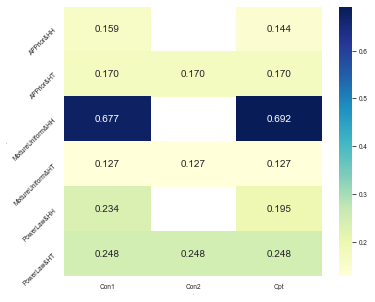

In [377]:
value = 'loss_er'
target_recall = 1.0
group_df = df[df['tr'] == target_recall].groupby(['smp', 'sc']).mean()
group_df = group_df.reset_index()

group_df.loc[(group_df['smp']=='APPriorSampler'), 'smp']= 'APPrior&HT'
group_df.loc[(group_df['smp']=='APPriorIPSampler'), 'smp']= 'APPrior&HH'
group_df.loc[(group_df['smp']=='MixtureUniformSampler_epsilon0.5'), 'smp']= 'MixtureUniform&HT'
group_df.loc[(group_df['smp']=='MixtureUniformIPSampler_epsilon0.5'), 'smp']= 'MixtureUniform&HH'
group_df.loc[(group_df['smp']=='PowerLawSampler_beta-0.8'), 'smp']= 'PowerLaw&HT'
group_df.loc[(group_df['smp']=='PowerLawIPSampler_beta-0.8'), 'smp']= 'PowerLaw&HH'
group_df.loc[(group_df['sc']=='loose'), 'sc']= 'Opt'
group_df.loc[(group_df['sc']=='strict1'), 'sc']= 'Con1'
group_df.loc[(group_df['sc']=='strict2'), 'sc']= 'Con2'


group_df.rename(columns={'smp':'samplingestimationmethod', 'sc': 'stoppingstrategy'})
# heatmap_df = group_df.pivot("samplingestimationmethod", "stoppingstrategy", value)
heatmap_df = group_df.pivot("smp", "sc", value)
# heatmap_df.rename(columns={'smp':'Sampling & estimation method', 'sc': 'Stopping strategy'})

plt.rcParams['xtick.labelsize'] = 6.5
plt.rcParams['ytick.labelsize'] = 6.5
plt.rcParams["legend.loc"]='lower right'
plt.figure(figsize=(8.27*0.7, 8.27*0.6)) # a4 paper size
plt.xlim(0, 1) 
plt.ylim(0, 1.05) 

sns_plot = sns.heatmap(heatmap_df, annot=True, fmt=".3f", cmap='YlGnBu') 
sns_plot.set_yticklabels(sns_plot.get_yticklabels(), rotation=45)

figure = sns_plot.get_figure() 
figure.savefig(os.path.join(paperfiguredir, 'component-{}-{}.pdf'.format(value.replace('_', ''), int(target_recall*100))))
    

In [357]:
plt.rcParams

/Users/danli/anaconda/envs/p3/lib/python3.6/site-packages/IPython/lib/pretty.py:689: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  output = repr(obj)


RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': True,
          'axes.edgecolor': '.8',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-7, 7],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.format

## clef 2017 test

In [107]:
dfs = []
for topic_id in clef_2017_test_topics:
    for target_recall in [1.0, 0.9, 0.8]:
        sampler_type = 'APPriorSampler'
        stop_condition = 'strict1'
        try:
            _df = TarEvalResultReader(data_name='clef2017', model_name='autostop_cttopicwise_md2_c1.0_sp1.0_sr1.0_smp{}_tr{}_sc{}'.format(sampler_type, target_recall, stop_condition), exp_id='1', train_test='test', topic_id=topic_id)
            _df['smp'] = sampler_type
            _df['sc'] = stop_condition
            _df['tr'] = target_recall
            dfs.append(_df)
        except:
            print(topic_id)
            
df = pd.concat(dfs, ignore_index=True)
df['reliability'] = df.apply(lambda row:1 if row['recall'] >= row['tr'] else 0, axis=1)
df['re'] = np.abs(df['recall'] - df['tr']) / df['tr']


In [108]:
descdf = df[df['tr'] == 0.8][show_columns]
descdf.describe()

,recall,cost,reliability,loss_er,re
count,30.000,30.000,30.000,30.000,30.000
mean,0.787,0.335,0.367,0.105,0.088
std,0.095,0.077,0.490,0.056,0.080
min,0.609,0.061,0.000,0.039,0.005
25%,0.743,0.304,0.000,0.058,0.022
50%,0.782,0.329,0.000,0.088,0.061
75%,0.817,0.386,1.000,0.135,0.122
max,1.000,0.482,1.000,0.232,0.250


In [110]:
descdf = df[df['tr'] == 0.9][show_columns]
descdf.describe()

,recall,cost,reliability,loss_er,re
count,30.000,30.000,30.000,30.000,30.000
mean,0.884,0.421,0.500,0.097,0.069
std,0.088,0.097,0.509,0.065,0.070
min,0.654,0.081,0.000,0.019,0.006
25%,0.847,0.381,0.000,0.049,0.026
50%,0.903,0.427,0.500,0.096,0.045
75%,0.931,0.490,1.000,0.124,0.080
max,1.000,0.551,1.000,0.276,0.274


In [109]:
descdf = df[df['tr'] == 1.0][show_columns]
descdf.describe()

,recall,cost,reliability,loss_er,re
count,30.000,30.000,30.000,30.000,30.000
mean,0.999,0.625,0.967,0.161,0.001
std,0.008,0.190,0.183,0.115,0.008
min,0.958,0.114,0.000,0.008,0.000
25%,1.000,0.529,1.000,0.088,0.000
50%,1.000,0.665,1.000,0.131,0.000
75%,1.000,0.745,1.000,0.216,0.000
max,1.000,0.962,1.000,0.558,0.042


## clef 2018

In [111]:
dfs = []
for topic_id in clef_2018_topics:
    for target_recall in [1.0, 0.9, 0.8]:
        sampler_type = 'APPriorSampler'
        stop_condition = 'strict1'
        try:
            _df = TarEvalResultReader(data_name='clef2018', model_name='autostop_cttopicwise_md2_c1.0_sp1.0_sr1.0_smp{}_tr{}_sc{}'.format(sampler_type, target_recall, stop_condition), exp_id='1', train_test='test', topic_id=topic_id)
            _df['smp'] = sampler_type
            _df['sc'] = stop_condition
            _df['tr'] = target_recall
            dfs.append(_df)
        except:
            print(topic_id)
            
df = pd.concat(dfs, ignore_index=True)
df['reliability'] = df.apply(lambda row:1 if row['recall'] >= row['tr'] else 0, axis=1)
df['re'] = np.abs(df['recall'] - df['tr']) / df['tr']


In [112]:
descdf = df[df['tr'] == 0.8][show_columns]
descdf.describe()

,recall,cost,reliability,loss_er,re
count,30.000,30.000,30.000,30.000,30.000
mean,0.781,0.347,0.467,0.104,0.064
std,0.073,0.089,0.507,0.061,0.069
min,0.577,0.041,0.000,0.041,0.000
25%,0.769,0.306,0.000,0.056,0.023
50%,0.795,0.342,0.000,0.085,0.036
75%,0.824,0.398,1.000,0.139,0.086
max,0.906,0.506,1.000,0.264,0.279


In [113]:
descdf = df[df['tr'] == 0.9][show_columns]
descdf.describe()

,recall,cost,reliability,loss_er,re
count,30.000,30.000,30.000,30.000,30.000
mean,0.892,0.441,0.600,0.098,0.046
std,0.075,0.103,0.498,0.078,0.071
min,0.625,0.050,0.000,0.014,0.000
25%,0.888,0.401,0.000,0.039,0.010
50%,0.905,0.439,1.000,0.090,0.022
75%,0.924,0.489,1.000,0.125,0.042
max,0.981,0.631,1.000,0.332,0.306


In [114]:
descdf = df[df['tr'] == 1.0][show_columns]
descdf.describe()

,recall,cost,reliability,loss_er,re
count,30.000,30.000,30.000,30.000,30.000
mean,0.992,0.662,0.967,0.163,0.008
std,0.044,0.182,0.183,0.136,0.044
min,0.758,0.096,0.000,0.012,0.000
25%,1.000,0.588,1.000,0.060,0.000
50%,1.000,0.685,1.000,0.140,0.000
75%,1.000,0.773,1.000,0.199,0.000
max,1.000,0.990,1.000,0.552,0.242


## clef 2019

In [115]:
dfs = []
for topic_id in clef_2019_topics:
    for target_recall in [1.0, 0.9, 0.8]:
        sampler_type = 'APPriorSampler'
        stop_condition = 'strict1'
        try:
            _df = TarEvalResultReader(data_name='clef2019', model_name='autostop_cttopicwise_md2_c1.0_sp1.0_sr1.0_smp{}_tr{}_sc{}'.format(sampler_type, target_recall, stop_condition), exp_id='1', train_test='test', topic_id=topic_id)
            _df['smp'] = sampler_type
            _df['sc'] = stop_condition
            _df['tr'] = target_recall
            dfs.append(_df)
        except:
            print(topic_id)
            
df = pd.concat(dfs, ignore_index=True)
df['reliability'] = df.apply(lambda row:1 if row['recall'] >= row['tr'] else 0, axis=1)
df['re'] = np.abs(df['recall'] - df['tr']) / df['tr']



In [116]:
descdf = df[df['tr'] == 0.8][show_columns]
descdf.describe()

,recall,cost,reliability,loss_er,re
count,31.000,31.000,31.000,31.000,31.000
mean,0.791,0.397,0.452,0.158,0.111
std,0.121,0.119,0.506,0.143,0.100
min,0.500,0.218,0.000,0.042,0.000
25%,0.732,0.325,0.000,0.093,0.023
50%,0.791,0.384,0.000,0.124,0.071
75%,0.823,0.439,1.000,0.176,0.190
max,1.000,0.776,1.000,0.829,0.375


In [117]:
descdf = df[df['tr'] == 0.9][show_columns]
descdf.describe()

,recall,cost,reliability,loss_er,re
count,31.000,31.000,31.000,31.000,31.000
mean,0.878,0.479,0.387,0.159,0.073
std,0.096,0.129,0.495,0.154,0.080
min,0.500,0.218,0.000,0.042,0.004
25%,0.838,0.396,0.000,0.067,0.031
50%,0.881,0.471,0.000,0.118,0.049
75%,0.938,0.551,1.000,0.180,0.100
max,1.000,0.799,1.000,0.863,0.444


In [118]:
descdf = df[df['tr'] == 1.0][show_columns]
descdf.describe()

,recall,cost,reliability,loss_er,re
count,31.0,31.000,31.0,31.000,31.0
mean,1.0,0.651,1.0,0.223,0.0
std,0.0,0.198,0.0,0.148,0.0
min,1.0,0.218,1.0,0.042,0.0
25%,1.0,0.538,1.0,0.124,0.0
50%,1.0,0.641,1.0,0.176,0.0
75%,1.0,0.782,1.0,0.295,0.0
max,1.0,0.971,1.0,0.641,0.0


## athome4

In [272]:
dfs = []
for topic_id in athome4_topics:
    for target_recall in [1.0, 0.9, 0.8]:
        sampler_type = 'APPriorSampler'
        stop_condition = 'strict1'
        try:
            _df = TarEvalResultReader(data_name='athome4', model_name='autostoplarge_cttopicwise_md2_c1.0_sp1.0_sr1.0_smp{}_tr{}_sc{}'.format(sampler_type, target_recall, stop_condition), exp_id='1', train_test='test', topic_id=topic_id)
            _df['smp'] = sampler_type
            _df['sc'] = stop_condition
            _df['tr'] = target_recall
            dfs.append(_df)
        except:
            print(topic_id)
            
df = pd.concat(dfs, ignore_index=True)
df['reliability'] = df.apply(lambda row:1 if row['recall'] >= row['tr'] else 0, axis=1)
df['re'] = np.abs(df['recall'] - df['tr']) / df['tr']

In [273]:
descdf = df[df['tr'] == 0.8][show_columns]
descdf.describe()

,recall,cost,reliability,loss_er,re
count,34.000,34.000,34.000,34.000,34.000
mean,0.885,0.754,0.912,0.115,0.111
std,0.053,0.174,0.288,0.153,0.056
min,0.759,0.394,0.000,0.014,0.017
25%,0.854,0.626,1.000,0.025,0.067
50%,0.880,0.813,1.000,0.044,0.100
75%,0.924,0.893,1.000,0.153,0.155
max,0.976,0.972,1.000,0.648,0.220


In [274]:
descdf = df[df['tr'] == 0.9][show_columns]
descdf.describe()

,recall,cost,reliability,loss_er,re
count,34.000,34.000,34.000,34.000,34.000
mean,0.953,0.766,0.941,0.103,0.062
std,0.030,0.163,0.239,0.158,0.027
min,0.866,0.433,0.000,0.005,0.014
25%,0.936,0.644,1.000,0.010,0.040
50%,0.955,0.816,1.000,0.020,0.061
75%,0.972,0.897,1.000,0.138,0.080
max,1.000,0.974,1.000,0.648,0.111


In [275]:
descdf = df[df['tr'] == 1.0][show_columns]
descdf.describe()

,recall,cost,reliability,loss_er,re
count,3.400e+01,34.000,34.000,34.000,3.400e+01
mean,1.000e+00,0.779,0.941,0.100,2.208e-05
std,9.497e-05,0.148,0.239,0.160,9.497e-05
min,9.995e-01,0.464,0.000,0.000,0.000e+00
25%,1.000e+00,0.677,1.000,0.005,0.000e+00
50%,1.000e+00,0.814,1.000,0.017,0.000e+00
75%,1.000e+00,0.896,1.000,0.136,0.000e+00
max,1.000e+00,0.974,1.000,0.648,5.028e-04


## legal

In [276]:
dfs = []
for topic_id in legal_t10_interactive_test_topics:
    for target_recall in [1.0, 0.9, 0.8]:
        sampler_type = 'APPriorSampler'
        stop_condition = 'strict1'
        try:
            _df = TarEvalResultReader(data_name='legal', model_name='autostoplarge_cttopicwise_md2_c1.0_sp1.0_sr1.0_smp{}_tr{}_sc{}'.format(sampler_type, target_recall, stop_condition), exp_id='1', train_test='test', topic_id=topic_id)
            _df['smp'] = sampler_type
            _df['sc'] = stop_condition
            _df['tr'] = target_recall
            dfs.append(_df)
        except:
            print(topic_id)
            
df = pd.concat(dfs, ignore_index=True)
df['reliability'] = df.apply(lambda row:1 if row['recall'] >= row['tr'] else 0, axis=1)
df['re'] = np.abs(df['recall'] - df['tr']) / df['tr']

In [277]:
descdf = df[df['tr'] == 0.8][show_columns]
descdf.describe()

,recall,cost,reliability,loss_er,re
count,2.000,2.000,2.0,2.000,2.000
mean,0.684,0.794,0.0,0.105,0.145
std,0.022,0.032,0.0,0.015,0.027
min,0.669,0.771,0.0,0.094,0.126
25%,0.676,0.782,0.0,0.099,0.135
50%,0.684,0.794,0.0,0.105,0.145
75%,0.692,0.805,0.0,0.110,0.154
max,0.699,0.817,0.0,0.115,0.164


In [278]:
descdf = df[df['tr'] == 0.9][show_columns]
descdf.describe()

,recall,cost,reliability,loss_er,re
count,2.000,2.000,2.0,2.000,2.000
mean,0.803,0.811,0.0,0.043,0.108
std,0.006,0.029,0.0,0.004,0.007
min,0.799,0.791,0.0,0.041,0.103
25%,0.801,0.801,0.0,0.042,0.105
50%,0.803,0.811,0.0,0.043,0.108
75%,0.805,0.821,0.0,0.045,0.110
max,0.808,0.831,0.0,0.046,0.113


In [279]:
descdf = df[df['tr'] == 1.0][show_columns]
descdf.describe()

,recall,cost,reliability,loss_er,re
count,2.000,2.000,2.0,2.000,2.000
mean,0.996,0.833,0.0,0.005,0.004
std,0.001,0.025,0.0,0.001,0.001
min,0.995,0.815,0.0,0.004,0.003
25%,0.995,0.824,0.0,0.005,0.004
50%,0.996,0.833,0.0,0.005,0.004
75%,0.996,0.842,0.0,0.006,0.005
max,0.997,0.851,0.0,0.006,0.005


# setting

In [124]:

data_name = 'clef2019'
target_recall = 1.0
tr = '08'
sampler = 'APPrior'
exp_ids = ['1']
topic_ids =  clef_2019_topics # set(clef_2017_topics) - set(example_topics) - set(['CD008643']) # set(athome4_topics) - set(['415'])

folders = [
'knee_sp1.0_sr1.0_rho6',
'scal_tr{}_'.format(target_recall),
'random_sp1.0_sr1.0_tr{}'.format(target_recall),
'autostop_sp1.0_sr1.0_update_sampler{}Sampler_auto_tr{}_scloose'.format(sampler, target_recall),
'autostop_sp1.0_sr1.0_update_sampler{}Sampler_auto_tr{}_scstrict1'.format(sampler, target_recall),
'autostop_sp1.0_sr1.0_update_sampler{}Sampler_auto_tr{}_scstrict2'.format(sampler, target_recall),
'autostop_sp1.0_sr1.0_update_sampler{}IPSampler_auto_tr{}_scloose'.format(sampler, target_recall),
'autostop_sp1.0_sr1.0_update_sampler{}IPSampler_auto_tr{}_scstrict1'.format(sampler, target_recall),
]

df1 = load_data(data_name=data_name, folders=folders, exp_ids=exp_ids, topic_ids=topic_ids, func=TarEvalResultReader)
df2 = load_data(data_name=data_name, folders=folders, exp_ids=exp_ids, topic_ids=topic_ids, func=InteractionLastResult)
df2 = df2[['model_name', 'exp_id', 'topic_id', 'ap', 'running_true_r', 'total_true_r']]

df = pd.merge(df1, df2, on=['model_name', 'exp_id', 'topic_id'])
df['normed_sampled_num'] = df['sampled_num']/df['total_num']
df['relative_error'] = np.abs(df['running_true_r'] - df['total_true_r']) / df['total_true_r']
df['relative_error_s'] = np.abs(df['true_stopped_recall'] - target_recall) / target_recall

df_mean = df.groupby(['model_name']).mean()
df_mean = df_mean.reset_index()
df_mean = df_mean.round(2)
df_mean = df_mean[['model_name', 'normed_sampled_num', 'true_stopped_recall', 'ap', 'relative_error', 'relative_error_s','losser']]
df_mean

not existing file /Users/danli/Documents/Project/autostop/autostop_project/ret/clef2019/tar_run/knee_sp1.0_sr1.0_rho6/1/test/CD006468.run
[Errno 2] No such file or directory: '/Users/danli/Documents/Project/autostop/autostop_project/ret/clef2019/tar_run/knee_sp1.0_sr1.0_rho6/1/test/CD006468.run' knee_sp1.0_sr1.0_rho6 1 CD006468
not existing file /Users/danli/Documents/Project/autostop/autostop_project/ret/clef2019/tar_run/knee_sp1.0_sr1.0_rho6/1/test/CD000996.run
[Errno 2] No such file or directory: '/Users/danli/Documents/Project/autostop/autostop_project/ret/clef2019/tar_run/knee_sp1.0_sr1.0_rho6/1/test/CD000996.run' knee_sp1.0_sr1.0_rho6 1 CD000996
not existing file /Users/danli/Documents/Project/autostop/autostop_project/ret/clef2019/tar_run/knee_sp1.0_sr1.0_rho6/1/test/CD001261.run
[Errno 2] No such file or directory: '/Users/danli/Documents/Project/autostop/autostop_project/ret/clef2019/tar_run/knee_sp1.0_sr1.0_rho6/1/test/CD001261.run' knee_sp1.0_sr1.0_rho6 1 CD001261
not existi

ValueError: No objects to concatenate

In [ ]:
knee = df[df['model_name'] == '2-scal']
autostop = df[df['model_name'] == '4-strict1']

In [ ]:
knee[['losser']].plot(kind='box')

In [ ]:
diff = knee['losser'].values - autostop['losser'].values
tempdf = pd.DataFrame(diff)

tempdf.plot(kind='hist')

from scipy import stats
stats.shapiro(diff)

stats.ttest_rel(knee['losser'].values, autostop['losser'].values)

# Table

In [ ]:
df1 = load_data(data_name=data_name, folders=folders, exp_ids=exp_ids, topic_ids=topic_ids, func=TarEvalResultReader)
df2 = load_data(data_name=data_name, folders=folders, exp_ids=exp_ids, topic_ids=topic_ids, func=InteractionLastResult)
df2 = df2[['model_name', 'exp_id', 'topic_id', 'ap', 'running_true_r', 'total_true_r']]

df = pd.merge(df1, df2, on=['model_name', 'exp_id', 'topic_id'])
df['normed_sampled_num'] = df['sampled_num']/df['total_num']
df['relative_error'] = np.abs(df['running_true_r'] - df['total_true_r']) / df['total_true_r']


In [ ]:
df_mean = df.groupby(['model_name']).mean()
df_mean = df_mean.reset_index()
df_mean = df_mean.round(2)
df_mean = df_mean[['model_name', 'normed_sampled_num', 'true_stopped_recall', 'ap', 'relative_error', 'losser']]
df_mean

# Recall_cost v.s. Cost


In [120]:


def plot_cost_recall(data_name, topic_ids, target_recall, beta, rho, target_rel_num, sub_percentage, bound_bt, ita, sample_percentage, sampler):
    exp_ids = ['1']
    sd_target_recall = 0.99 if target_recall == 1.0 else target_recall
    autostop = 'autostoplarge' if 'athome' in data_name or 'legal' in data_name else 'autostop'
    
    if target_recall == 1.0:
        folders = [
        'knee_sb{}_sp1.0_sr1.0_rho{}_cttopicwise_md2_c1.0'.format(beta, rho),
        'target_sp1.0_sr1.0_md2_c1.0_trn{}'.format(target_rel_num),
        'scal_sp1.0_sr1.0_tr{}_md2_c1.0_spt{}_bnd{}_min_bktsamplerel_ita{}'.format(target_recall, sub_percentage, bound_bt, ita),
        'sdtf_tr{}'.format(sd_target_recall),
        'sdfu_smp{}_tr{}'.format(sample_percentage, sd_target_recall),
        '{}_cttopicwise_md2_c1.0_sp1.0_sr1.0_smp{}Sampler_tr{}_scstrict1'.format(autostop, sampler, target_recall),
        ]
        markers = ['X', '*', 'o', 'D', 's', 'v']
#         labels = ['', 'Knee', 'Target', 'SCAL', 'SD-training', 'SD-sampling', 'Ours'] 
    else:
        folders = [
        'scal_sp1.0_sr1.0_tr{}_md2_c1.0_spt{}_bnd{}_min_bktsamplerel_ita{}'.format(target_recall, sub_percentage, bound_bt, ita),
        'sdtf_tr{}'.format(sd_target_recall),
        'sdfu_smp{}_tr{}'.format(sample_percentage, sd_target_recall),
        '{}_cttopicwise_md2_c1.0_sp1.0_sr1.0_smp{}Sampler_tr{}_scstrict1'.format(autostop, sampler, target_recall),
        ]
        markers = ['o', 'D', 's', 'v']
#         labels = ['', 'SCAL', 'SD-training', 'SD-sampling', 'Ours'] 
        
    df = load_data(data_name=data_name, folders=folders, exp_ids=exp_ids, topic_ids=topic_ids, func=TarEvalResultReader)

    df_mean = df.groupby(['model_name']).mean()
    df_mean = df_mean.reset_index()
    df_mean = df_mean.round(2)
    df_mean = df_mean[['model_name', 'cost', 'recall', 'loss_er']]
    
    params = {
            'xtick.labelsize': 14,
             'ytick.labelsize': 14,
        'axes.labelsize': 14,
             'legend.loc': 'lower right',
            'legend.fontsize': 14,
          'legend.handlelength': 1}
    matplotlib.rcParams.update(params)

    plt.figure(figsize=(8.27*0.5, 8.27*0.5)) # a4 paper size
    plt.xlim(0, 1.05) 
    plt.ylim(0, 1.05) 
    
    sns_plot = sns.scatterplot(x='cost', y='recall', hue='model_name', style='model_name', 
                               markers=markers, edgecolor='none', alpha=0.9, data=df_mean, legend='brief')

    p_frontX, p_frontY = pareto_frontier(df_mean['cost'].values, df_mean['recall'].values, maxX=False)
    sns_plot = sns.lineplot(p_frontX, p_frontY, color='grey', linewidth='1')
    
    sns_plot.xaxis.set_major_locator(plt.MaxNLocator(6))
    sns_plot.yaxis.set_major_locator(plt.MaxNLocator(6))
    sns_plot.set_xlabel('Cost')
    sns_plot.set_ylabel('$Recall$')
#     handles, _ = sns_plot.get_legend_handles_labels()
#     sns_plot.legend(handles, labels)

    figure = sns_plot.get_figure() 
    figure.savefig(os.path.join(paperfiguredir, '{}-tr{}-pareto.pdf'.format(data_name, int(target_recall*10))), bbox_inches='tight')

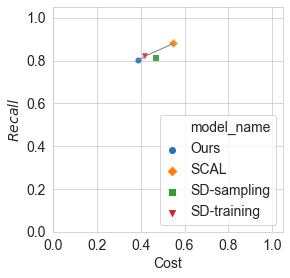

In [127]:

data_name = 'clef2019'
topic_ids = clef_2019_test_topics 
target_recall = 0.8
beta = 1000.0
rho = 'dynamic'
target_rel_num = 15
sub_percentage = 0.8
bound_bt = 50
ita = 1.05
sample_percentage = 0.4
sampler = 'APPrior'
plot_cost_recall(data_name, topic_ids, target_recall, beta, rho, target_rel_num, sub_percentage, bound_bt, ita, sample_percentage, sampler)



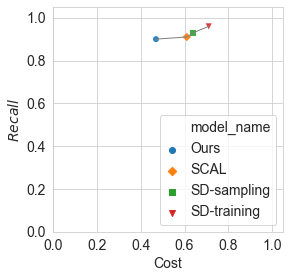

In [129]:

data_name = 'clef2019'
topic_ids = clef_2019_test_topics 
target_recall = 0.9
beta = 1000.0
rho = 'dynamic'
target_rel_num = 15
sub_percentage = 0.8
bound_bt = 70
ita = 1.05
sample_percentage = 0.3
sampler = 'APPrior'

plot_cost_recall(data_name, topic_ids, target_recall, beta, rho, target_rel_num, sub_percentage, bound_bt, ita, sample_percentage, sampler)


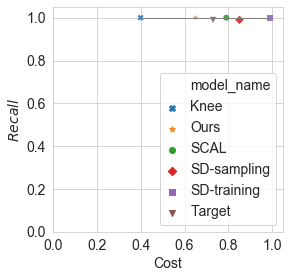

In [131]:

data_name = 'clef2019'
topic_ids = clef_2019_test_topics 
target_recall = 1.0
beta = 1000.0
rho = 'dynamic'
target_rel_num = 15
sub_percentage = 1.0
bound_bt = 110
ita = 1.05
sample_percentage = 0.2
sampler = 'APPrior'
plot_cost_recall(data_name, topic_ids, target_recall, beta, rho, target_rel_num, sub_percentage, bound_bt, ita, sample_percentage, sampler)



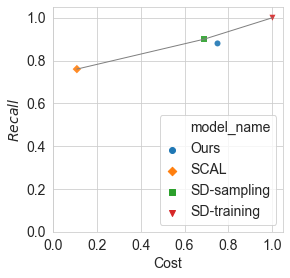

In [136]:

data_name = 'athome4'
topic_ids = athome4_topics 
target_recall = 0.8
beta = 1000.0
rho = 10
target_rel_num = 15
sub_percentage = 0.8
bound_bt = 70
ita = 1.05
sample_percentage = 0.1
sampler = 'APPrior'
plot_cost_recall(data_name, topic_ids, target_recall, beta, rho, target_rel_num, sub_percentage, bound_bt, ita, sample_percentage, sampler)



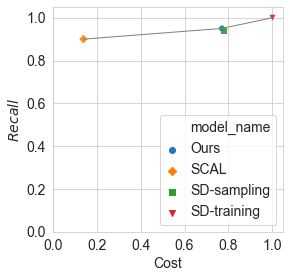

In [137]:

data_name = 'athome4'
topic_ids = athome4_topics 
target_recall = 0.9
beta = 1000.0
rho = 10
target_rel_num = 15
sub_percentage = 1.0
bound_bt = 110
ita = 1.05
sample_percentage = 0.1
sampler = 'APPrior'
plot_cost_recall(data_name, topic_ids, target_recall, beta, rho, target_rel_num, sub_percentage, bound_bt, ita, sample_percentage, sampler)




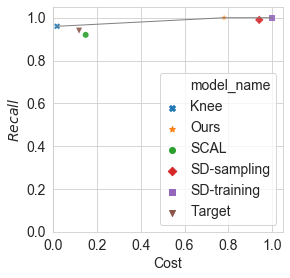

In [138]:

data_name = 'athome4'
topic_ids = athome4_topics 
target_recall = 1.0
beta = 1000.0
rho = 10
target_rel_num = 15
sub_percentage = 1.0
bound_bt = 110
ita = 1.05
sample_percentage = 0.1
sampler = 'APPrior'
plot_cost_recall(data_name, topic_ids, target_recall, beta, rho, target_rel_num, sub_percentage, bound_bt, ita, sample_percentage, sampler)




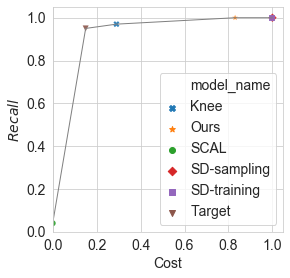

In [123]:

data_name = 'legal'
topic_ids = legal_t10_interactive_test_topics 
target_recall = 1.0
beta = 1000.0
rho = 'dynamic'
target_rel_num = 10
sub_percentage = 1.0
bound_bt = 30
ita = 1.05
sample_percentage = 0.1
sampler = 'APPrior'
plot_cost_recall(data_name, topic_ids, target_recall, beta, rho, target_rel_num, sub_percentage, bound_bt, ita, sample_percentage, sampler)




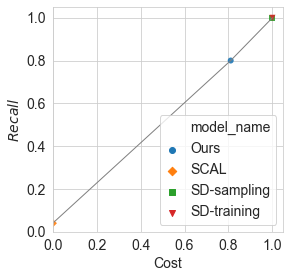

In [124]:

data_name = 'legal'
topic_ids = legal_t10_interactive_test_topics 
target_recall = 0.9
beta = 1000.0
rho = 'dynamic'
target_rel_num = 10
sub_percentage = 1.0
bound_bt = 30
ita = 1.05
sample_percentage = 0.1
sampler = 'APPrior'
plot_cost_recall(data_name, topic_ids, target_recall, beta, rho, target_rel_num, sub_percentage, bound_bt, ita, sample_percentage, sampler)



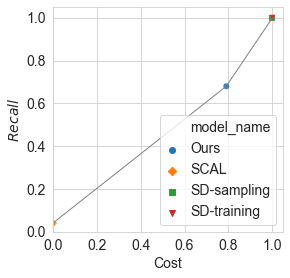

In [125]:

data_name = 'legal'
topic_ids = legal_t10_interactive_test_topics 
target_recall = 0.8
beta = 1000.0
rho = 'dynamic'
target_rel_num = 10
sub_percentage = 1.0
bound_bt = 30
ita = 1.05
sample_percentage = 0.1
sampler = 'APPrior'
plot_cost_recall(data_name, topic_ids, target_recall, beta, rho, target_rel_num, sub_percentage, bound_bt, ita, sample_percentage, sampler)



# topic-wise

In [146]:


def plot_cost_recall_topicwise(data_name, topic_ids, target_recall, beta, rho, target_rel_num, sub_percentage, bound_bt, ita, sample_percentage, sampler):
    exp_ids = ['1']
    sd_target_recall = 0.99 if target_recall == 1.0 else target_recall
    autostop = 'autostoplarge' if 'athome' in data_name or 'legal' in data_name else 'autostop'
    
    if target_recall == 1.0:
        folders = [
        'knee_sb{}_sp1.0_sr1.0_rho{}_cttopicwise_md2_c1.0'.format(beta, rho),
        'target_sp1.0_sr1.0_md2_c1.0_trn{}'.format(target_rel_num),
        'scal_sp1.0_sr1.0_tr{}_md2_c1.0_spt{}_bnd{}_min_bktsamplerel_ita{}'.format(target_recall, sub_percentage, bound_bt, ita),
        'sdtf_tr{}'.format(sd_target_recall),
        'sdfu_smp{}_tr{}'.format(sample_percentage, sd_target_recall),
        '{}_cttopicwise_md2_c1.0_sp1.0_sr1.0_smp{}Sampler_tr{}_scstrict1'.format(autostop, sampler, target_recall),
        ]
        markers = ['X', '*', 'o', 'D', 's', 'v']
#         labels = ['', 'Knee', 'Target', 'SCAL', 'SD-training', 'SD-sampling', 'Ours'] 
    else:
        folders = [
        'scal_sp1.0_sr1.0_tr{}_md2_c1.0_spt{}_bnd{}_min_bktsamplerel_ita{}'.format(target_recall, sub_percentage, bound_bt, ita),
        'sdtf_tr{}'.format(sd_target_recall),
        'sdfu_smp{}_tr{}'.format(sample_percentage, sd_target_recall),
        '{}_cttopicwise_md2_c1.0_sp1.0_sr1.0_smp{}Sampler_tr{}_scstrict1'.format(autostop, sampler, target_recall),
        ]
        markers = ['o', 'D', 's', 'v']
#         labels = ['', 'SCAL', 'SD-training', 'SD-sampling', 'Ours'] 
        
    df = load_data(data_name=data_name, folders=folders, exp_ids=exp_ids, topic_ids=topic_ids, func=TarEvalResultReader)

#     df_mean = df.groupby(['model_name']).mean()
#     df_mean = df_mean.reset_index()
#     df_mean = df_mean.round(2)
#     df_mean = df_mean[['model_name', 'cost', 'recall', 'loss_er']]

    params = {
        'xtick.labelsize': 14,
         'ytick.labelsize': 14,
        'axes.labelsize': 14,
         'legend.loc': 'lower right',
        'legend.fontsize': 14,
      'legend.handlelength': 1}
    matplotlib.rcParams.update(params)
    
    plt.figure(figsize=(8.27*0.5, 8.27*0.5)) # a4 paper size
    plt.xlim(0, 1.05) 
    plt.ylim(0, 1.05) 
    sns_plot = sns.scatterplot(x='cost', y='recall', hue='model_name', style='model_name', 
                               markers=markers, edgecolor='none', alpha=0.8, s=26, data=df, legend='brief')

#     p_frontX, p_frontY = pareto_frontier(df_mean['cost'].values, df_mean['recall'].values, maxX=False)
#     sns_plot = sns.lineplot(p_frontX, p_frontY, color='grey', linewidth='1')
    sns_plot.xaxis.set_major_locator(plt.MaxNLocator(6))
    sns_plot.yaxis.set_major_locator(plt.MaxNLocator(6))
    sns_plot.set_xlabel('Cost')
    sns_plot.set_ylabel('$Recall$')
#     handles, _ = sns_plot.get_legend_handles_labels()
#     sns_plot.legend(handles, labels)

    figure = sns_plot.get_figure() 
    figure.savefig(os.path.join(paperfiguredir, '{}-tr{}-pareto-topicwise.pdf'.format(data_name, int(target_recall*100))), bbox_inches='tight')
    

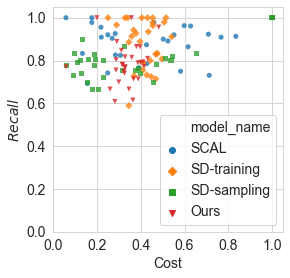

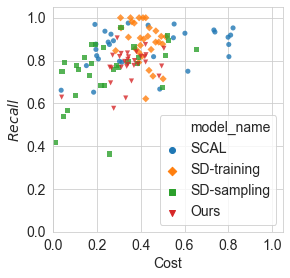

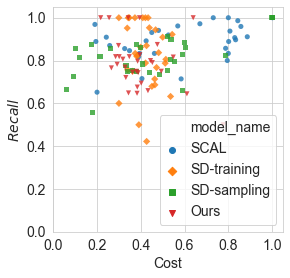

In [147]:

for data_name, topic_ids in[('clef2017',clef_2017_test_topics),
                            ('clef2018',clef_2018_topics),
                            ('clef2019',clef_2019_topics)]:

    target_recall = 0.8
    beta = 1000.0
    rho = 'dynamic'
    target_rel_num = 15
    sub_percentage = 0.8
    bound_bt = 50
    ita = 1.05
    sample_percentage = 0.4
    sampler = 'APPrior'
    plot_cost_recall_topicwise(data_name, topic_ids, target_recall, beta, rho, target_rel_num, sub_percentage, bound_bt, ita, sample_percentage, sampler)



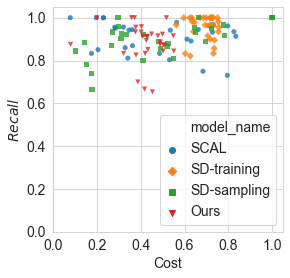

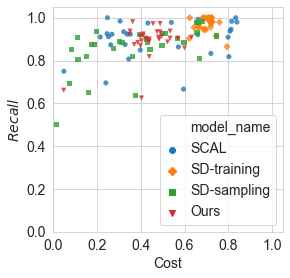

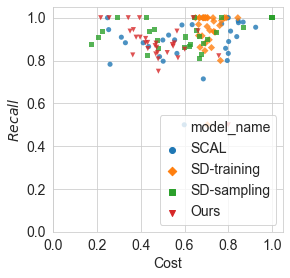

In [148]:

for data_name, topic_ids in[('clef2017',clef_2017_test_topics),
                            ('clef2018',clef_2018_topics),
                            ('clef2019',clef_2019_topics)]: 
    target_recall = 0.9
    beta = 1000.0
    rho = 'dynamic'
    target_rel_num = 15
    sub_percentage = 0.8
    bound_bt = 70
    ita = 1.05
    sample_percentage = 0.3
    sampler = 'APPrior'


    plot_cost_recall_topicwise(data_name, topic_ids, target_recall, beta, rho, target_rel_num, sub_percentage, bound_bt, ita, sample_percentage, sampler)





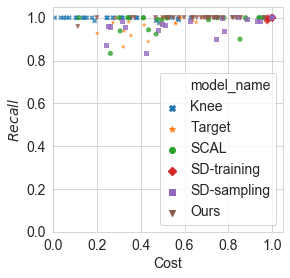

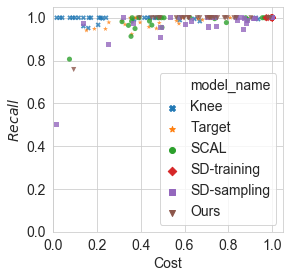

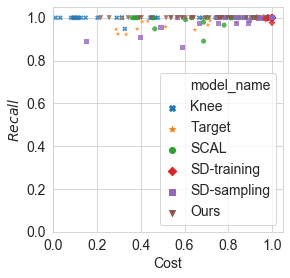

In [149]:

for data_name, topic_ids in[('clef2017',clef_2017_test_topics),
                            ('clef2018',clef_2018_topics),
                            ('clef2019',clef_2019_topics)]:
    target_recall = 1.0
    beta = 1000.0
    rho = 'dynamic'
    target_rel_num = 15
    sub_percentage = 1.0
    bound_bt = 110
    ita = 1.05
    sample_percentage = 0.2
    sampler = 'APPrior'

    plot_cost_recall_topicwise(data_name, topic_ids, target_recall, beta, rho, target_rel_num, sub_percentage, bound_bt, ita, sample_percentage, sampler)




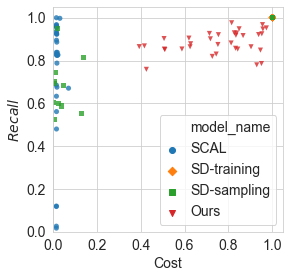

In [150]:

data_name = 'athome4'
topic_ids = athome4_topics 
target_recall = 0.8
beta = 1000.0
rho = 10
target_rel_num = 15
sub_percentage = 0.8
bound_bt = 70
ita = 1.05
sample_percentage = 0.1
sampler = 'APPrior'
plot_cost_recall_topicwise(data_name, topic_ids, target_recall, beta, rho, target_rel_num, sub_percentage, bound_bt, ita, sample_percentage, sampler)


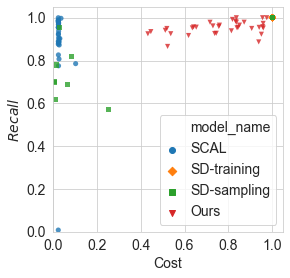

In [151]:

data_name = 'athome4'
topic_ids = athome4_topics 
target_recall = 0.9
beta = 1000.0
rho = 10
target_rel_num = 15
sub_percentage = 1.0
bound_bt = 110
ita = 1.05
sample_percentage = 0.1
sampler = 'APPrior'
plot_cost_recall_topicwise(data_name, topic_ids, target_recall, beta, rho, target_rel_num, sub_percentage, bound_bt, ita, sample_percentage, sampler)


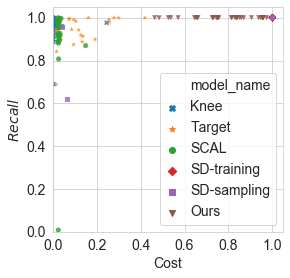

In [152]:

data_name = 'athome4'
topic_ids = athome4_topics 
target_recall = 1.0
beta = 1000.0
rho = 10
target_rel_num = 15
sub_percentage = 1.0
bound_bt = 110
ita = 1.05
sample_percentage = 0.1
sampler = 'APPrior'
plot_cost_recall_topicwise(data_name, topic_ids, target_recall, beta, rho, target_rel_num, sub_percentage, bound_bt, ita, sample_percentage, sampler)


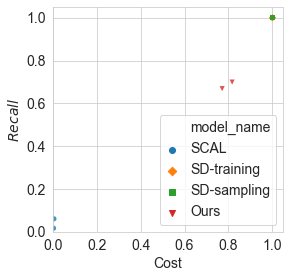

In [153]:

data_name = 'legal'
topic_ids = legal_t10_interactive_test_topics 
target_recall = 0.8
beta = 1000.0
rho = 'dynamic'
target_rel_num = 10
sub_percentage = 1.0
bound_bt = 30
ita = 1.05
sample_percentage = 0.1
sampler = 'APPrior'
plot_cost_recall_topicwise(data_name, topic_ids, target_recall, beta, rho, target_rel_num, sub_percentage, bound_bt, ita, sample_percentage, sampler)




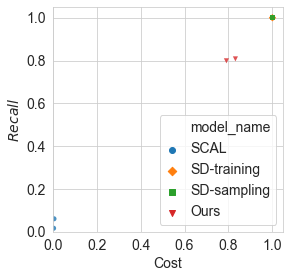

In [154]:

data_name = 'legal'
topic_ids = legal_t10_interactive_test_topics 
target_recall = 0.9
beta = 1000.0
rho = 'dynamic'
target_rel_num = 10
sub_percentage = 1.0
bound_bt = 30
ita = 1.05
sample_percentage = 0.1
sampler = 'APPrior'
plot_cost_recall_topicwise(data_name, topic_ids, target_recall, beta, rho, target_rel_num, sub_percentage, bound_bt, ita, sample_percentage, sampler)



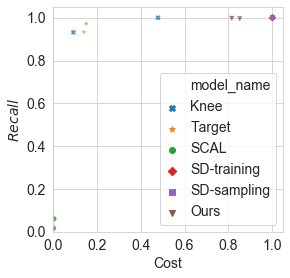

In [155]:

data_name = 'legal'
topic_ids = legal_t10_interactive_test_topics 
target_recall = 1.0
beta = 1000.0
rho = 'dynamic'
target_rel_num = 10
sub_percentage = 1.0
bound_bt = 30
ita = 1.05
sample_percentage = 0.1
sampler = 'APPrior'
plot_cost_recall_topicwise(data_name, topic_ids, target_recall, beta, rho, target_rel_num, sub_percentage, bound_bt, ita, sample_percentage, sampler)




# Topicwise $R$ v.s. $\widehat{R}$

In [166]:


def plot_truer_estir_topicwise(data_name, topic_ids, target_recall, beta, rho, target_rel_num, sub_percentage, bound_bt, ita, sample_percentage, sampler):
    exp_ids = ['1']
    sd_target_recall = 0.99 if target_recall == 1.0 else target_recall

    folders = [
    'scal_sp1.0_sr1.0_tr{}_md2_c1.0_spt{}_bnd{}_min_bktsamplerel_ita{}'.format(target_recall, sub_percentage, bound_bt, ita),
    'autostop_cttopicwise_md2_c1.0_sp1.0_sr1.0_smp{}Sampler_tr{}_scstrict1'.format(sampler, target_recall),
    ]
    markers = ['X', '*']
    
    def revise_scal(x):
        total_esti_r = x['total_esti_r']
        if x['model_name'] == 'SCAL':
            total_esti_r *= ita
        return total_esti_r
    
#     def calculate_bias_crossrate(df, model_name):
#         dff = df[df['model_name'] == model_name]
#         seris = dff['revised_total_esti_r'] - dff['total_true_r']
#         bias = seris.mean()
        
#         total_cnt = len(dff)
        
#         cross_cnt1 = len(dff[(dff['total_true_r'] <= dff['upper_bound']) &
#                              (dff['total_true_r'] >= dff['lower_bound'])])
#         cross_rate1 = cross_cnt1 / total_cnt
        
#         cross_cnt2 = len(dff[(dff['total_true_r'] <= dff['revised_total_esti_r'] +  2*np.sqrt(dff['var1'])) &
#                              (dff['total_true_r'] >= dff['revised_total_esti_r'] -  2*np.sqrt(dff['var1']))])
#         cross_rate2 = cross_cnt1 / total_cnt
        
#         cross_cnt3 = len(dff[(dff['total_true_r'] <= dff['revised_total_esti_r'] +  3*np.sqrt(dff['var1'])) &
#                              (dff['total_true_r'] >= dff['revised_total_esti_r'] -  3*np.sqrt(dff['var1']))])
#         cross_rate3 = cross_cnt3 / total_cnt
        
#         return round(bias, 2), int(cross_rate1*100), int(cross_rate2*100), int(cross_rate3*100)
    
    def calculate_mse(df, model_name):
        dff = df[df['model_name'] == model_name]
        seris = (dff['revised_total_esti_r'] - dff['total_true_r'])**2
        mse = seris.mean()
      
        return round(mse, 2)
    
        
    df = load_data(data_name=data_name, folders=folders, exp_ids=exp_ids, topic_ids=topic_ids, func=InteractionLastResult)

    df['revised_total_esti_r'] = df.apply(revise_scal, axis=1)
    df.loc[df['var1'] <= 0, 'var1'] = 0 
    df['lower_bound'] = df['revised_total_esti_r'] -  np.sqrt(df['var1'])
    df['upper_bound'] = df['revised_total_esti_r'] +  np.sqrt(df['var1'])
    
    
    params = {
        'xtick.labelsize': 14,
         'ytick.labelsize': 14,
        'axes.labelsize': 14,
         'legend.loc': 'lower right',
        'legend.fontsize': 14,
      'legend.handlelength': 1}
    matplotlib.rcParams.update(params)
    
    plt.figure(figsize=(8.27*0.5, 8.27*0.5)) 
    plt.xlim(-10, 240) 
    plt.ylim(-10, 240) 
    sns_plot=sns.scatterplot(x='total_true_r', y='revised_total_esti_r', hue='model_name',style='model_name', 
                             markers=['*', '.'], edgecolor='none', alpha=0.8, s=80, data=df)
    sns_plot=sns.lineplot([-10, 550], [-10, 550], linewidth= 0.2, dashes=True, color='grey')

    plt.vlines(x=df[df['model_name'] == 'Ours']['total_true_r'].values, 
               ymin=df[df['model_name'] == 'Ours']['lower_bound'].values, 
               ymax=df[df['model_name'] == 'Ours']['upper_bound'].values, color='orange', linewidth=0.5)


    mse = calculate_mse(df, 'Ours')
    mse_ = calculate_mse(df, 'SCAL')
    sns_plot.text(1,230, 'MSE:{} (Ours), {} (SCAL)'.format(mse, mse_), fontsize=12) 
    
    
    sns_plot.set_xlabel('R')
    sns_plot.set_ylabel('$\widehat{R}$', rotation=0)
    figure = sns_plot.get_figure() 


    figure.savefig(os.path.join(paperfiguredir, '{}-tr{}-truer-estir-topicwise.pdf'.format(data_name, int(target_recall*100))), bbox_inches='tight')



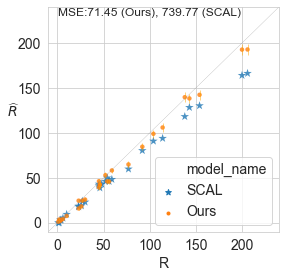

In [167]:

data_name = 'clef2017'
topic_ids = clef_2017_test_topics 
target_recall = 0.8
beta = 1000.0
rho = 'dynamic'
target_rel_num = 15
sub_percentage = 0.8
bound_bt = 50
ita = 1.05
sample_percentage = 0.4
sampler = 'APPrior'
plot_truer_estir_topicwise(data_name, topic_ids, target_recall, beta, rho, target_rel_num, sub_percentage, bound_bt, ita, sample_percentage, sampler)




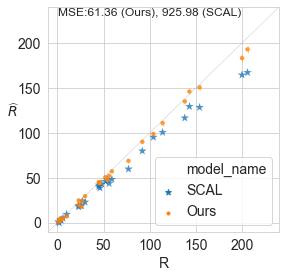

In [168]:

data_name = 'clef2017'
topic_ids = clef_2017_test_topics 
target_recall = 0.9
beta = 1000.0
rho = 'dynamic'
target_rel_num = 15
sub_percentage = 0.8
bound_bt = 70
ita = 1.05
sample_percentage = 0.3
sampler = 'APPrior'

plot_truer_estir_topicwise(data_name, topic_ids, target_recall, beta, rho, target_rel_num, sub_percentage, bound_bt, ita, sample_percentage, sampler)




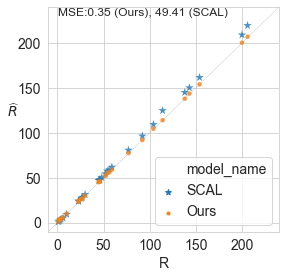

In [169]:

data_name = 'clef2017'
topic_ids = clef_2017_test_topics 
target_recall = 1.0
beta = 1000.0
rho = 'dynamic'
target_rel_num = 15
sub_percentage = 1.0
bound_bt = 110
ita = 1.05
sample_percentage = 0.2
sampler = 'APPrior'
plot_truer_estir_topicwise(data_name, topic_ids, target_recall, beta, rho, target_rel_num, sub_percentage, bound_bt, ita, sample_percentage, sampler)




# AP/Recall/RE as a function of cost

In [73]:


def plot_recall_cost_curve(data_name, topic_ids):

    autostop_df = load_data(data_name=data_name, folders=['autostop_cttopicwise_md2_c1.0_sp1.0_sr1.0_smpAPPriorSampler_tr1.0_scstrict1'], exp_ids=['1'], topic_ids=topic_ids, func=InteractionResultReader)
    autotar_df = load_data(data_name=data_name, folders=['autotar_sp1.0_sr1.0_cttopicwise_md2_c1.0'], exp_ids=['1'], topic_ids=topic_ids, func=InteractionResultReader)
    
    params = {'xtick.labelsize': 12,
             'ytick.labelsize': 12}
    matplotlib.rcParams.update(params)
    matplotlib.rcParams["legend.loc"]='lower right'
    
    fig, ax = plt.subplots(figsize=(8.27*0.6, 8.27*0.6)) 
    ax2 = ax.twinx() 
    sns_plot=sns.lineplot(x='percentage', y='recall', hue='model_name', style='model_name', ax=ax, markers=['o'], data=autostop_df)
    
    sns_plot=sns.lineplot(x='percentage', y='relative_error', hue='model_name', style='model_name', ax=ax2, markers=['<'], data=autostop_df)
    
    sns_plot=sns.lineplot(x='percentage', y='recall', color='grey', ax=ax, data=autotar_df)
    
    ax.set_xlabel('$Cost$')
    ax.set_ylabel('$Recall$', rotation=90)
    ax2.set_ylabel('$RE$', rotation=90)
    ax.set_ylim(0, 1.05) 
    ax2.set_ylim(0, 1.05) 
    ax2.grid(False)
    ax.get_legend().set_visible(False)
    ax2.get_legend().set_visible(False)
    figure = sns_plot.get_figure() 

    figure.savefig(os.path.join(paperfiguredir, '{}-recall-re.pdf'.format(data_name)))




not existing file /Users/danli/Documents/Project/autostop/autostop_project/ret/clef2017/interaction/autotar_sp1.0_sr1.0_cttopicwise_md2_c1.0/1/test/CD010409.csv
[Errno 2] No such file or directory: '/Users/danli/Documents/Project/autostop/autostop_project/ret/clef2017/interaction/autotar_sp1.0_sr1.0_cttopicwise_md2_c1.0/1/test/CD010409.csv' autotar_sp1.0_sr1.0_cttopicwise_md2_c1.0 1 CD010409


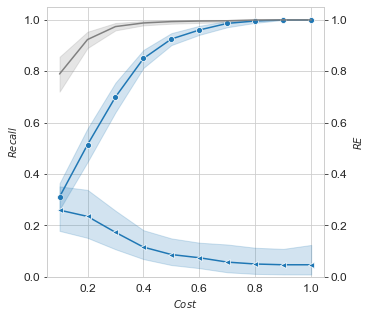

In [74]:

data_name = 'clef2017'
topic_ids = clef_2017_test_topics 

plot_recall_cost_curve(data_name, topic_ids)

In [ ]:
autotar_df_mean

In [ ]:
import matplotlib.lines as mlines
params = {'legend.fontsize': 10,
          'legend.handlelength': 1}
matplotlib.rcParams.update(params)
matplotlib.rcParams["legend.loc"]='upper left'

colors = sns.color_palette("muted", 2)

fig, ax = plt.subplots(figsize=(8.27*0.5, 8.27*0.5)) 
# ax2 = ax.twinx() 

ax = sns.lineplot(x='percentage', y='recall', color=colors[0], marker='o', ax=ax, legend=False, data=autostop_df_mean)
# ax2 = sns.lineplot(x='percentage', y='relative_error', color=colors[1], marker='D', ax=ax2, legend=False, data=autostop_df_mean)
ax = sns.lineplot(x='percentage', y='recall',  color='black', marker='o', ax=ax, legend=False, data=autotar_df_mean)

ax.set(xlabel='$cost$', ylabel='$recall$', xlim=[0,1], ylim=[0,1.1])
# ax2.set(xlabel='$cost$', ylabel='$RE$', xlim=[0,1], ylim=[0,1.1])

# handle1 = mlines.Line2D([], [],  marker='o', markersize=6, color=colors[0])
# handle2 = mlines.Line2D([], [],  marker='D', markersize=6, color=colors[1])
# ax.legend([handle1, handle2], ['$recall_c$', '$RE$'])
# ax.annotate('AutoTAR', color='black', fontsize=12, xy=(0.4, 1.0), xytext=(0.4, 1.05),
#                              arrowprops={"arrowstyle":"simple", "color":'black'})

fig.savefig(os.path.join(paperfiguredir, '{}-{}-{}-recall-re.pdf'.format(data_name, estimator, sampler)))

In [ ]:
import matplotlib.lines as mlines
params = {'legend.fontsize': 10,
          'legend.handlelength': 1}
matplotlib.rcParams.update(params)
matplotlib.rcParams["legend.loc"]='upper left'

colors = sns.color_palette("muted", 2)

fig, ax = plt.subplots(figsize=(8.27*0.5, 8.27*0.5)) 
# ax2 = ax.twinx() 

ax = sns.lineplot(x='percentage', y='ap', color=colors[0], marker='o', ax=ax, legend=False, data=autostop_df_mean)
# ax2 = sns.lineplot(x='percentage', y='relative_error', color=colors[1], marker='D', ax=ax2, legend=False, data=autostop_df_mean)
ax = sns.lineplot(x='percentage', y='ap',  color='black', marker='o', ax=ax, legend=False, data=autotar_df_mean)

ax.set(xlabel='$cost$', ylabel='$AP$', xlim=[0,1], ylim=[0,1.1])
# ax2.set(xlabel='$cost$', ylabel='$RE$', xlim=[0,1], ylim=[0,1.1])

# handle1 = mlines.Line2D([], [],  marker='o', markersize=6, color=colors[0])
# handle2 = mlines.Line2D([], [],  marker='D', markersize=6, color=colors[1])
# ax.legend([handle1, handle2], ['$AP$', '$RE$'])
# ax.annotate('AutoTAR', color='black', fontsize=12, xy=(0.4, 0.74), xytext=(0.3, 0.9),
#                              arrowprops={"arrowstyle":"simple", "color":'black'})

fig.savefig(os.path.join(paperfiguredir, '{}-{}-{}-ap-re.pdf'.format(data_name, estimator, sampler)))